# Cube Reprojection Tutorial

## Authors
Adam Ginsburg, Eric Koch

## Learning Goals
* reproject a cube spectrally
* smooth it spectrally
* reproject it spatially

## Keywords
spectral cube, radio astronomy, astroquery, units, dask

## Summary
Spectroscopic cube observations taken at different wavelength can trace the motion of gas or stars using spectral lines, but often lines at different wavelengths give different information.
For example, one might observe a galaxy in the 21cm line of HI and the 115 GHz line of CO, or a protoplanetary disk in a line of N2H+ and a line of CO, or a galactic disk in the H-alpha and H-beta lines (in absorption or emission).
In order to compare these data sets pixel-by-pixel, they must be placed onto a common grid with common resolution.

This tutorial shows how to take two spectral cubes observed toward the same part of the sky, but different frequencies, and put them onto the same grid using [spectral-cube](spectral-cube.readthedocs.io).

It uses [astroquery](https://astroquery.readthedocs.io/) to obtain line frequencies from [splatalogue](https://astroquery.readthedocs.io/en/latest/splatalogue/splatalogue.html); this example uses radio-wavelength data for which Splatalogue's molecular line lists are appropriate.
Finally, it shows how to do the reprojection using [dask](https://dask.org) to enable parallelization.

## Index 

 * [Step 1: Download](#Step-1:-Download-the-data)
 * [Step 2: Open files, collect metadata](#Step-2:-Load-the-cubes)
 * [Step 3: Convert to velocity](#Step-3:-Convert-cubes-from-frequency-to-velocity)
 * [Step 4: Spectral Interpolation](#Step-4.-Spectral-Interpolation)
 * [Step 5: Spatial Smoothing](#Step-5.-Spatial-Smoothing)
 * [Step 6: Reprojection](#Step-6.-Reprojection)
 
 
In this example, we do spectral smoothing and interpolation (step 4) before spatial smoothing and interpolation (step 5), but if you have a varying-resolution cube (with a different beam size for each channel), you have to do spatial smoothing first.   For more information see the [spectral-cube documentation](spectral-cube.readthedocs.io).

## Step 1: Download the data

(you might not have to do this step, since you may already have data)

In [1]:
import numpy as np
from astropy.utils.data import download_file

We download two example spectral cubes of a point in the Galactic center from a permalink on the ALMA archives.
These are moderately large files, with sizes 18 MB and 337 MB.

If you have trouble with these downloads, try changing to a different ALMA server (e.g., almascience.eso.org->almascience.nrao.edu) or increase the timeout.  See the [download_file](https://docs.astropy.org/en/stable/api/astropy.utils.data.download_file.html) documentation.

In [2]:
filename_1 = download_file("https://almascience.eso.org/dataPortal/member.uid___A001_X1465_X3a33.BrickMaser_sci.spw71.cube.I.manual.image.pbcor.fits",
                           cache=True)

In [3]:
filename_2 = download_file("https://almascience.eso.org/dataPortal/member.uid___A001_X87d_X141.a_sma1_sci.spw27.cube.I.pbcor.fits",
                          cache=True)

## Step 2: Load the cubes

In [4]:
from spectral_cube import SpectralCube

In [5]:
cube1 = SpectralCube.read(filename_1)
cube1

SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: FREQ      unit_s: Hz     range: 139434992275.503 Hz:139503942362.300 Hz

In [6]:
cube2 = SpectralCube.read(filename_2)
cube2

SpectralCube with shape=(478, 420, 420) and unit=Jy / beam:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:    478  type_s: FREQ      unit_s: Hz     range: 216957714464.027 Hz:217190639088.700 Hz

The cubes are at different frequencies - 139 and 217 GHz.

The first cube covers the H2CS 4(1,3)-3(1,2) line at 139.483699	GHz.

The second covers SiO v=5-4 at 217.104984 GHz

We use the `find_lines` tool to query [splatalogue](https://splatalogue.online/) with [astroquery](https://astroquery.readthedocs.io/en/latest/splatalogue/splatalogue.html) over the spectral range covered by the cube.  It returns a table of matching lines.  Note that some line names will be repeated because Splatalogue includes several different databases and most chemical species are present in all of these.

In [7]:
cube1.find_lines(chemical_name=' H2CS ').show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Linelist
0,H2CS,Thioformaldehyde,--,--,139.48341,0.00028,"4(1,3)-3(1,2)",-3.2185,30.51674,11.223,-4.44732,0.17,16.1465,23.23108,20.79917,29.92519,JPL
1,H2CS,Thioformaldehyde,--,--,139.4836816,5e-05,"4(1,3)-3(1,2)",-3.2182,30.59661,11.251,-4.44619,--,16.1329,23.21151,20.78557,29.90563,CDMS
2,H2CS,Thioformaldehyde,139.483699,1.7e-05,139.483741,2.4e-05,"4(1,3)-3(1,2)",0.0,30.59472,3.75,-3.94426,0.17,16.133,23.21165,20.78568,29.90578,SLAIM
3,H2CS,Thioformaldehyde,139.483699,1.7e-05,--,--,"4(1,3)-3(1,2)",0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,Lovas


In [8]:
cube2.find_lines(chemical_name='SiO').show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Linelist
0,"SiO,v=0-10",Silicon monoxide (global fit),--,--,217.104919,2e-06,"J=5-4,v=0-0",-1.3211,47.9909,0.0,-3.28429,--,14.4843,20.83981,21.72614,31.25927,CDMS
1,SiOv=0,Silicon Monoxide,--,--,217.10498,8e-05,5-4,-1.3211,47.99147,5.0,-3.28429,1.6,14.4843,20.83956,21.72614,31.25889,CDMS
2,SiOv=0,Silicon Monoxide,--,--,217.10498,5e-05,5-4,-1.3199,47.9911,5.0,-3.28429,1.6,14.4843,20.83956,21.72614,31.25889,CDMS
3,SiOv=0,Silicon Monoxide,--,--,217.10498,8e-05,5-4,-1.3166,48.14651,5.0,-3.28288,1.6,14.4843,20.83956,21.72614,31.25889,JPL
4,SiOv=0,Silicon Monoxide,217.104984,1.4e-05,--,--,5-4,0.0,0.0,0.0,0.0,1.6,0.0,0.0,0.0,0.0,Lovas
5,SiOv=0,Silicon Monoxide,217.104984,1.4e-05,217.10498,0.0001,5-4,0.0,47.6849,5.0,-3.28706,--,14.484,20.83913,21.72584,31.25846,SLAIM


## Step 3: Convert cubes from frequency to velocity

To compare the kinematic structure of the target, we need to convert from the observed frequency (which must be in a common reference frame; in this case, it already is) to the doppler velocity.

In [9]:
from astropy import units as u

In [10]:
cube1vel = cube1.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=139.483699*u.GHz)
cube1vel

SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

In [11]:
cube2vel = cube2.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=217.104984*u.GHz)
cube2vel

SpectralCube with shape=(478, 420, 420) and unit=Jy / beam:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:    478  type_s: VRAD      unit_s: km / s  range:     -118.278 km / s:     203.359 km / s

From the shape of the cube, we can see the H2CS cube is narrower in velocity, so we'll use that as the target spectral reprojection.  However, the SiO cube is the smaller footprint on the sky.

### Create spatial maps of the peak intensity to quickly explore the cubes:
    
One way to quickly explore the structure in the data cubes is to produce a peak intensity map, or the maximum along the spectral axis (`axis=0`).

/opt/hostedtoolcache/Python/3.9.13/x64/lib/python3.9/site-packages/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


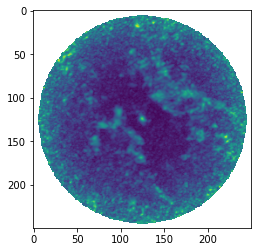

In [12]:
mx = cube1.max(axis=0)
mx.quicklook()

We can do the same thing all on one line (for the other cube this time):

/opt/hostedtoolcache/Python/3.9.13/x64/lib/python3.9/site-packages/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


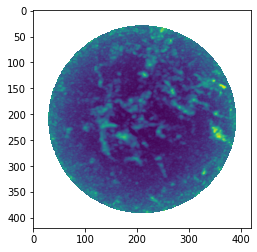

In [13]:
cube2.max(axis=0).quicklook()

# Step 4. Spectral Interpolation

We can choose to do either the spatial or spectral step first.  
In this case, we choose the spectral step first because the H$_2$CS cube is narrower in velocity (`cube1vel`) and this will reduce the number of channels we need to spatially interpolate over in the next step.

We need to match resolution to the cube with the largest channel width:

In [14]:
velocity_res_1 = np.diff(cube1vel.spectral_axis)[0]
velocity_res_2 = np.diff(cube2vel.spectral_axis)[0]
velocity_res_1, velocity_res_2

(<Quantity 2.00262828 km / s>, <Quantity 0.67429189 km / s>)

Next, we will reduce `cube2vel` to have the same spectral range as `cube1vel`:

In [15]:
cube2vel_cutout = cube2vel.spectral_slab(cube1vel.spectral_axis.min(),
                                         cube1vel.spectral_axis.max())
cube1vel, cube2vel_cutout

(SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s,
 SpectralCube with shape=(221, 420, 420) and unit=Jy / beam:
  n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
  n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
  n_s:    221  type_s: VRAD      unit_s: km / s  range:      -43.432 km / s:     104.913 km / s)

Note that it is important for the to-be-interpolated cube, in this case `cube2`, to have pixels bounding `cube1`'s spectral axis, but in this case it does not.  If the pixel range doesn't overlap perfectly, it may blank out one of the edge pixels.  So, to fix this, we add a little buffer:

In [16]:
cube2vel_cutout = cube2vel.spectral_slab(cube1vel.spectral_axis.min() - velocity_res_2,
                                         cube1vel.spectral_axis.max())
cube1vel, cube2vel_cutout

(SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s,
 SpectralCube with shape=(222, 420, 420) and unit=Jy / beam:
  n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
  n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
  n_s:    222  type_s: VRAD      unit_s: km / s  range:      -44.106 km / s:     104.913 km / s)

Our H2CS cube (`cube1vel`) has broader channels.  We need to first smooth `cube2vel` to the broader channel width before doing the spatial reprojection.

To do this, we will spectrally smooth with a Gaussian with width set such that smoothing `cube2vel` will result in the same width as `cube1vel`.   We do this by finding the difference in widths when deconvolving the `cube1vel` channel width from `cube2vel`. For further information see the [documentation on smoothing](https://spectral-cube.readthedocs.io/en/latest/smoothing.html#spectral-smoothing).

Note that if we did not do this smoothing step, we would under-sample the `cube2vel` data in the next downsampling step, reducing our signal-to-noise ratio.

We have adopted a width equal to the channel width; the [line spread function](https://help.almascience.org/kb/articles/what-spectral-resolution-will-i-get-for-a-given-channel-spacing) is actually a Hanning-smoothed tophat.  We are making a coarse approximation here.

In [17]:
fwhm_gaussian = (velocity_res_1**2 - velocity_res_2**2)**0.5
fwhm_gaussian

<Quantity 1.88569628 km / s>

In [18]:
from astropy.convolution import Gaussian1DKernel
fwhm_to_sigma = np.sqrt(8*np.log(2))
# we want the kernel in pixel units, so we force to km/s and take the value
spectral_smoothing_kernel = Gaussian1DKernel(stddev=fwhm_gaussian.to(u.km/u.s).value / fwhm_to_sigma)

We then smooth with the kernel.  Note that this is doing 420x420 = 176400 smoothing operations on a length-221 spectrum: it will take a little time

In [19]:
cube2vel_smooth = cube2vel_cutout.spectral_smooth(spectral_smoothing_kernel)

Now that we've done spectral smoothing, we can resample the spectral axis of `cube2vel_smooth` to match `cube1vel` by interpolating `cube2vel_smooth` onto `cube1vel`'s grid:

In [20]:
cube2vel_spectralresample = cube2vel_smooth.spectral_interpolate(cube1vel.spectral_axis,
                                                                 suppress_smooth_warning=True)
cube2vel_spectralresample

SpectralCube with shape=(75, 420, 420) and unit=Jy / beam:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

Note that we included the `suppress_smooth_warning=True` argument.  That is to hide this warning:
```
WARNING: SmoothingWarning: Input grid has too small a spacing. The data should be smoothed prior to resampling. [spectral_cube.spectral_cube]
```
which will tell you if the operation will under-sample the original data.  The smoothing work we did above is specifically to make sure we are properly sampling, so this warning does not apply.

# Step 5. Spatial Smoothing

Now that we've done spectral smoothing, we also need to follow a similar procedure of smoothing then resampling for the spatial axes.  

The `beam` is the resolution element of our cubes:

In [21]:
cube1vel.beam, cube2vel_spectralresample.beam

(Beam: BMAJ=1.29719604986604 arcsec BMIN=1.04247149438736 arcsec BPA=82.95313553702 deg,
 Beam: BMAJ=0.8935712308515601 arcsec BMIN=0.6649610689789199 arcsec BPA=85.81119797802 deg)

`cube1` again hase the larger beam, so we'll smooth `cube2` to its resolution

#### Aside: mixed beams 

If cube1 and cube2 had different sized beams, but neither was clearly larger, we would have to convolve _both_ to a [common beam](https://radio-beam.readthedocs.io/en/latest/commonbeam.html#finding-the-smallest-common-beam).

In this case, it's redundant and we could have just used `cube1`'s beam, but this is the more general approach:

In [22]:
import radio_beam
common_beam = radio_beam.commonbeam.common_2beams(radio_beam.Beams(beams=[cube1vel.beam, cube2vel.beam]))
common_beam

Beam: BMAJ=1.29719604986604 arcsec BMIN=1.04247149438736 arcsec BPA=82.95313553702 deg

We then convolve:

In [23]:
# for v<0.6, we convert to Kelvin to ensure the units are preserved:
# cube2vel_spatialspectralsmooth = cube2vel_spectralresample.to(u.K).convolve_to(common_beam)
# in more recent versions, the unit conversion is handled appropriately,
# so unit conversion isn't needed
cube2vel_spatialspectralsmooth = cube2vel_spectralresample.convolve_to(common_beam)
cube2vel_spatialspectralsmooth

SpectralCube with shape=(75, 420, 420) and unit=Jy / beam:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

# Step 6. Reprojection

Now we can do the spatial resampling as the final step for producing two cubes matched to the same spatial and spectral pixel grid:

In [24]:
cube2vel_reproj = cube2vel_spatialspectralsmooth.reproject(cube1vel.header)
cube2vel_reproj

SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

These two cubes are now on an identical grid, and can be directly compared:

In [25]:
cube2vel_reproj, cube1vel

(SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s,
 SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s)

These spectra can now be overplotted as they are in the same unit with the same beam.

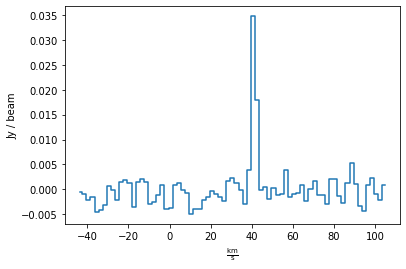

In [26]:
cube1vel[:,125,125].quicklook()
cube2vel_reproj[:,125,125].quicklook()

# Dask

All of the above can be done using `dask` as the underlying framework to parallelize the operations.
See [the spectral-cube documentation on dask integration](https://spectral-cube.readthedocs.io/en/latest/dask.html) or the [dask documentation](https://dask.org/) for further details.

The dask approach can be made more memory-efficient (avoid using too much RAM) by writing intermediate steps to disk.  The non-dask approach used above will generally need to read the whole cube into memory.  Depending on the situation, either approach may be faster, but `dask` may be needed if the cube is larger than memory.

We repeat all the operations above using dask.  We use a `ProgressBar` so you can see how long it takes.  We also suppress warnings to make the output look cleaner (we already saw all the important warnings above).

In [27]:
from dask.diagnostics import ProgressBar
import warnings

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    with ProgressBar():
        cube2dask = SpectralCube.read(filename_2, use_dask=True)
        cube2daskvel = cube2dask.with_spectral_unit(u.km/u.s,
                                            velocity_convention='radio', rest_value=217.104984*u.GHz)
        cube2daskvel_cutout = cube2daskvel.spectral_slab(cube1vel.spectral_axis.min() - velocity_res_2,
                                                 cube1vel.spectral_axis.max())
        cube2daskvel_smooth = cube2daskvel_cutout.spectral_smooth(spectral_smoothing_kernel)
        cube2daskvel_spectralresample = cube2daskvel_smooth.spectral_interpolate(cube1vel.spectral_axis,
                                                                             suppress_smooth_warning=True)
        cube2daskvel_spatialspectralsmooth = cube2daskvel_spectralresample.convolve_to(common_beam)
        cube2daskvel_reproj = cube2daskvel_spatialspectralsmooth.reproject(cube1vel.header)
cube2daskvel_reproj

[                                        ] | 0% Completed |  0.0s

[                                        ] | 0% Completed |  0.1s

[                                        ] | 0% Completed |  0.2s

[                                        ] | 0% Completed |  0.3s

[                                        ] | 0% Completed |  0.4s

[                                        ] | 0% Completed |  0.5s

[                                        ] | 0% Completed |  0.6s

[                                        ] | 0% Completed |  0.7s

[                                        ] | 0% Completed |  0.8s

[                                        ] | 0% Completed |  0.9s

[                                        ] | 0% Completed |  1.0s

[                                        ] | 0% Completed |  1.1s

[                                        ] | 0% Completed |  1.2s

[                                        ] | 0% Completed |  1.3s

[                                        ] | 0% Completed |  1.4s

[                                        ] | 0% Completed |  1.5s

[                                        ] | 0% Completed |  1.7s

[                                        ] | 0% Completed |  1.8s

[                                        ] | 0% Completed |  1.9s

[                                        ] | 0% Completed |  2.0s

[                                        ] | 0% Completed |  2.1s

[                                        ] | 0% Completed |  2.2s

[                                        ] | 0% Completed |  2.3s

[                                        ] | 0% Completed |  2.4s

[                                        ] | 0% Completed |  2.5s

[                                        ] | 0% Completed |  2.6s

[                                        ] | 0% Completed |  2.7s

[                                        ] | 0% Completed |  2.8s

[                                        ] | 0% Completed |  2.9s

[                                        ] | 0% Completed |  3.0s

[                                        ] | 0% Completed |  3.1s

[                                        ] | 0% Completed |  3.2s

[                                        ] | 0% Completed |  3.3s

[                                        ] | 0% Completed |  3.4s

[                                        ] | 0% Completed |  3.5s

[                                        ] | 0% Completed |  3.6s

[                                        ] | 0% Completed |  3.7s

[                                        ] | 0% Completed |  3.8s

[                                        ] | 0% Completed |  3.9s

[                                        ] | 0% Completed |  4.0s

[                                        ] | 0% Completed |  4.1s

[                                        ] | 0% Completed |  4.2s

[                                        ] | 0% Completed |  4.3s

[                                        ] | 0% Completed |  4.4s

[                                        ] | 0% Completed |  4.5s

[                                        ] | 0% Completed |  4.6s

[                                        ] | 0% Completed |  4.7s

[                                        ] | 0% Completed |  4.8s

[                                        ] | 0% Completed |  4.9s

[                                        ] | 0% Completed |  5.0s

[                                        ] | 0% Completed |  5.1s

[                                        ] | 0% Completed |  5.2s

[                                        ] | 0% Completed |  5.3s

[                                        ] | 0% Completed |  5.4s

[                                        ] | 0% Completed |  5.5s

[                                        ] | 0% Completed |  5.6s

[                                        ] | 0% Completed |  5.7s

[                                        ] | 0% Completed |  5.8s

[                                        ] | 0% Completed |  5.9s

[                                        ] | 0% Completed |  6.0s

[                                        ] | 0% Completed |  6.1s

[                                        ] | 0% Completed |  6.2s

[                                        ] | 0% Completed |  6.3s

[                                        ] | 0% Completed |  6.4s

[                                        ] | 0% Completed |  6.5s

[                                        ] | 0% Completed |  6.6s

[                                        ] | 0% Completed |  6.7s

[                                        ] | 0% Completed |  6.8s

[                                        ] | 0% Completed |  6.9s

[                                        ] | 0% Completed |  7.0s

[                                        ] | 0% Completed |  7.1s

[                                        ] | 0% Completed |  7.2s

[                                        ] | 0% Completed |  7.3s

[                                        ] | 0% Completed |  7.4s

[                                        ] | 0% Completed |  7.5s

[                                        ] | 0% Completed |  7.6s

[                                        ] | 0% Completed |  7.7s

[                                        ] | 0% Completed |  7.8s

[                                        ] | 0% Completed |  7.9s

[                                        ] | 0% Completed |  8.0s

[                                        ] | 0% Completed |  8.1s

[                                        ] | 0% Completed |  8.2s

[                                        ] | 0% Completed |  8.3s

[                                        ] | 0% Completed |  8.4s

[                                        ] | 0% Completed |  8.5s

[                                        ] | 0% Completed |  8.6s

[                                        ] | 0% Completed |  8.7s

[                                        ] | 0% Completed |  8.8s

[                                        ] | 0% Completed |  8.9s

[                                        ] | 0% Completed |  9.0s

[                                        ] | 0% Completed |  9.1s

[                                        ] | 0% Completed |  9.2s

[                                        ] | 0% Completed |  9.3s

[                                        ] | 0% Completed |  9.4s

[                                        ] | 0% Completed |  9.5s

[                                        ] | 0% Completed |  9.6s

[                                        ] | 0% Completed |  9.7s

[                                        ] | 0% Completed |  9.8s

[                                        ] | 0% Completed |  9.9s

[                                        ] | 0% Completed | 10.0s

[                                        ] | 0% Completed | 10.1s

[                                        ] | 0% Completed | 10.2s

[                                        ] | 0% Completed | 10.3s

[                                        ] | 0% Completed | 10.4s

[                                        ] | 0% Completed | 10.5s

[                                        ] | 0% Completed | 10.6s

[                                        ] | 0% Completed | 10.7s

[                                        ] | 0% Completed | 10.8s

[                                        ] | 0% Completed | 10.9s

[                                        ] | 0% Completed | 11.0s

[                                        ] | 0% Completed | 11.1s

[                                        ] | 0% Completed | 11.2s

[                                        ] | 0% Completed | 11.3s

[                                        ] | 0% Completed | 11.4s

[                                        ] | 0% Completed | 11.5s

[                                        ] | 0% Completed | 11.6s

[                                        ] | 0% Completed | 11.7s

[                                        ] | 0% Completed | 11.8s

[                                        ] | 0% Completed | 11.9s

[                                        ] | 0% Completed | 12.0s

[                                        ] | 0% Completed | 12.1s

[                                        ] | 0% Completed | 12.3s

[                                        ] | 0% Completed | 12.4s

[                                        ] | 0% Completed | 12.5s

[                                        ] | 0% Completed | 12.6s

[                                        ] | 0% Completed | 12.7s

[                                        ] | 0% Completed | 12.8s

[                                        ] | 0% Completed | 12.9s

[                                        ] | 0% Completed | 13.0s

[                                        ] | 0% Completed | 13.1s

[                                        ] | 0% Completed | 13.2s

[                                        ] | 0% Completed | 13.3s

[                                        ] | 0% Completed | 13.4s

[                                        ] | 0% Completed | 13.5s

[                                        ] | 0% Completed | 13.6s

[                                        ] | 0% Completed | 13.7s

[                                        ] | 0% Completed | 13.8s

[                                        ] | 0% Completed | 13.9s

[                                        ] | 0% Completed | 14.0s

[                                        ] | 0% Completed | 14.1s

[                                        ] | 0% Completed | 14.2s

[                                        ] | 0% Completed | 14.3s

[                                        ] | 0% Completed | 14.4s

[                                        ] | 0% Completed | 14.5s

[                                        ] | 0% Completed | 14.6s

[                                        ] | 0% Completed | 14.7s

[                                        ] | 0% Completed | 14.8s

[                                        ] | 0% Completed | 14.9s

[                                        ] | 0% Completed | 15.0s

[                                        ] | 0% Completed | 15.1s

[                                        ] | 0% Completed | 15.2s

[                                        ] | 0% Completed | 15.3s

[                                        ] | 0% Completed | 15.4s

[                                        ] | 0% Completed | 15.5s

[                                        ] | 0% Completed | 15.6s

[                                        ] | 0% Completed | 15.7s

[                                        ] | 0% Completed | 15.8s

[                                        ] | 0% Completed | 15.9s

[                                        ] | 0% Completed | 16.0s

[                                        ] | 0% Completed | 16.1s

[                                        ] | 0% Completed | 16.2s

[                                        ] | 0% Completed | 16.3s

[                                        ] | 0% Completed | 16.4s

[                                        ] | 0% Completed | 16.5s

[                                        ] | 0% Completed | 16.6s

[                                        ] | 0% Completed | 16.7s

[                                        ] | 0% Completed | 16.8s

[                                        ] | 0% Completed | 16.9s

[                                        ] | 0% Completed | 17.0s

[                                        ] | 0% Completed | 17.1s

[                                        ] | 0% Completed | 17.2s

[                                        ] | 0% Completed | 17.3s

[                                        ] | 0% Completed | 17.4s

[                                        ] | 0% Completed | 17.5s

[                                        ] | 0% Completed | 17.6s

[                                        ] | 0% Completed | 17.7s

[                                        ] | 0% Completed | 17.8s

[                                        ] | 0% Completed | 17.9s

[                                        ] | 0% Completed | 18.0s

[                                        ] | 0% Completed | 18.1s

[                                        ] | 0% Completed | 18.2s

[                                        ] | 0% Completed | 18.3s

[                                        ] | 0% Completed | 18.4s

[                                        ] | 0% Completed | 18.5s

[                                        ] | 0% Completed | 18.6s

[                                        ] | 0% Completed | 18.7s

[                                        ] | 0% Completed | 18.8s

[                                        ] | 0% Completed | 18.9s

[                                        ] | 0% Completed | 19.0s

[                                        ] | 0% Completed | 19.1s

[                                        ] | 0% Completed | 19.2s

[                                        ] | 0% Completed | 19.3s

[                                        ] | 0% Completed | 19.4s

[                                        ] | 0% Completed | 19.5s

[                                        ] | 0% Completed | 19.6s

[                                        ] | 0% Completed | 19.7s

[                                        ] | 0% Completed | 19.8s

[                                        ] | 0% Completed | 19.9s

[                                        ] | 0% Completed | 20.0s

[                                        ] | 0% Completed | 20.1s

[                                        ] | 0% Completed | 20.2s

[                                        ] | 0% Completed | 20.3s

[                                        ] | 0% Completed | 20.4s

[                                        ] | 0% Completed | 20.5s

[                                        ] | 0% Completed | 20.6s

[                                        ] | 0% Completed | 20.7s

[                                        ] | 0% Completed | 20.8s

[                                        ] | 0% Completed | 20.9s

[                                        ] | 0% Completed | 21.0s

[                                        ] | 0% Completed | 21.1s

[                                        ] | 0% Completed | 21.2s

[                                        ] | 0% Completed | 21.3s

[                                        ] | 0% Completed | 21.4s

[                                        ] | 0% Completed | 21.5s

[                                        ] | 0% Completed | 21.6s

[                                        ] | 0% Completed | 21.7s

[                                        ] | 0% Completed | 21.8s

[                                        ] | 0% Completed | 21.9s

[                                        ] | 0% Completed | 22.0s

[                                        ] | 0% Completed | 22.1s

[                                        ] | 0% Completed | 22.2s

[                                        ] | 0% Completed | 22.3s

[                                        ] | 0% Completed | 22.4s

[                                        ] | 0% Completed | 22.5s

[                                        ] | 0% Completed | 22.6s

[                                        ] | 0% Completed | 22.7s

[                                        ] | 0% Completed | 22.8s

[                                        ] | 0% Completed | 22.9s

[                                        ] | 0% Completed | 23.0s

[                                        ] | 0% Completed | 23.1s

[                                        ] | 0% Completed | 23.2s

[                                        ] | 0% Completed | 23.3s

[                                        ] | 0% Completed | 23.4s

[                                        ] | 0% Completed | 23.5s

[                                        ] | 0% Completed | 23.6s

[                                        ] | 0% Completed | 23.7s

[                                        ] | 0% Completed | 23.8s

[                                        ] | 0% Completed | 23.9s

[                                        ] | 0% Completed | 24.0s

[                                        ] | 0% Completed | 24.1s

[                                        ] | 0% Completed | 24.2s

[                                        ] | 0% Completed | 24.4s

[                                        ] | 0% Completed | 24.5s

[                                        ] | 0% Completed | 24.6s

[                                        ] | 0% Completed | 24.7s

[                                        ] | 0% Completed | 24.8s

[                                        ] | 0% Completed | 24.9s

[                                        ] | 0% Completed | 25.0s

[                                        ] | 0% Completed | 25.1s

[                                        ] | 0% Completed | 25.2s

[                                        ] | 0% Completed | 25.3s

[                                        ] | 0% Completed | 25.4s

[                                        ] | 0% Completed | 25.5s

[                                        ] | 0% Completed | 25.6s

[                                        ] | 0% Completed | 25.7s

[                                        ] | 0% Completed | 25.8s

[                                        ] | 0% Completed | 25.9s

[                                        ] | 0% Completed | 26.0s

[                                        ] | 0% Completed | 26.1s

[                                        ] | 0% Completed | 26.2s

[                                        ] | 0% Completed | 26.3s

[                                        ] | 0% Completed | 26.4s

[                                        ] | 0% Completed | 26.5s

[                                        ] | 0% Completed | 26.6s

[                                        ] | 0% Completed | 26.7s

[                                        ] | 0% Completed | 26.8s

[                                        ] | 0% Completed | 26.9s

[                                        ] | 0% Completed | 27.0s

[                                        ] | 0% Completed | 27.1s

[                                        ] | 0% Completed | 27.2s

[                                        ] | 0% Completed | 27.3s

[                                        ] | 0% Completed | 27.4s

[                                        ] | 0% Completed | 27.5s

[                                        ] | 0% Completed | 27.6s

[                                        ] | 0% Completed | 27.7s

[                                        ] | 0% Completed | 27.8s

[                                        ] | 0% Completed | 27.9s

[                                        ] | 0% Completed | 28.0s

[                                        ] | 0% Completed | 28.1s

[                                        ] | 0% Completed | 28.2s

[                                        ] | 0% Completed | 28.3s

[                                        ] | 0% Completed | 28.4s

[                                        ] | 0% Completed | 28.5s

[                                        ] | 0% Completed | 28.6s

[                                        ] | 0% Completed | 28.7s

[                                        ] | 0% Completed | 28.8s

[                                        ] | 0% Completed | 28.9s

[                                        ] | 0% Completed | 29.0s

[                                        ] | 0% Completed | 29.1s

[                                        ] | 0% Completed | 29.2s

[                                        ] | 0% Completed | 29.3s

[                                        ] | 0% Completed | 29.4s

[                                        ] | 0% Completed | 29.5s

[                                        ] | 0% Completed | 29.6s

[                                        ] | 0% Completed | 29.7s

[                                        ] | 0% Completed | 29.8s

[                                        ] | 0% Completed | 29.9s

[                                        ] | 0% Completed | 30.0s

[                                        ] | 0% Completed | 30.1s

[                                        ] | 0% Completed | 30.2s

[                                        ] | 0% Completed | 30.3s

[                                        ] | 0% Completed | 30.4s

[                                        ] | 0% Completed | 30.5s

[                                        ] | 0% Completed | 30.6s

[                                        ] | 0% Completed | 30.7s

[                                        ] | 0% Completed | 30.8s

[                                        ] | 0% Completed | 30.9s

[                                        ] | 0% Completed | 31.0s

[                                        ] | 0% Completed | 31.1s

[                                        ] | 0% Completed | 31.2s

[                                        ] | 0% Completed | 31.3s

[                                        ] | 0% Completed | 31.4s

[                                        ] | 0% Completed | 31.5s

[                                        ] | 0% Completed | 31.6s

[                                        ] | 0% Completed | 31.7s

[                                        ] | 0% Completed | 31.8s

[                                        ] | 0% Completed | 31.9s

[                                        ] | 0% Completed | 32.0s

[                                        ] | 0% Completed | 32.1s

[                                        ] | 0% Completed | 32.2s

[                                        ] | 0% Completed | 32.3s

[                                        ] | 0% Completed | 32.4s

[                                        ] | 0% Completed | 32.5s

[                                        ] | 0% Completed | 32.6s

[                                        ] | 0% Completed | 32.7s

[                                        ] | 0% Completed | 32.8s

[                                        ] | 0% Completed | 32.9s

[                                        ] | 0% Completed | 33.0s

[                                        ] | 0% Completed | 33.1s

[                                        ] | 0% Completed | 33.2s

[                                        ] | 0% Completed | 33.3s

[                                        ] | 0% Completed | 33.4s

[                                        ] | 0% Completed | 33.5s

[                                        ] | 0% Completed | 33.6s

[                                        ] | 0% Completed | 33.7s

[                                        ] | 0% Completed | 33.8s

[                                        ] | 0% Completed | 33.9s

[                                        ] | 0% Completed | 34.0s

[                                        ] | 0% Completed | 34.1s

[                                        ] | 0% Completed | 34.2s

[                                        ] | 0% Completed | 34.3s

[                                        ] | 0% Completed | 34.4s

[                                        ] | 0% Completed | 34.5s

[                                        ] | 0% Completed | 34.6s

[                                        ] | 0% Completed | 34.7s

[                                        ] | 0% Completed | 34.8s

[                                        ] | 0% Completed | 34.9s

[                                        ] | 0% Completed | 35.0s

[                                        ] | 0% Completed | 35.1s

[                                        ] | 0% Completed | 35.2s

[                                        ] | 0% Completed | 35.3s

[                                        ] | 0% Completed | 35.4s

[                                        ] | 0% Completed | 35.5s

[                                        ] | 0% Completed | 35.6s

[                                        ] | 0% Completed | 35.7s

[                                        ] | 0% Completed | 35.9s

[                                        ] | 0% Completed | 36.0s

[                                        ] | 0% Completed | 36.1s

[                                        ] | 0% Completed | 36.2s

[                                        ] | 0% Completed | 36.3s

[                                        ] | 0% Completed | 36.4s

[                                        ] | 0% Completed | 36.5s

[                                        ] | 0% Completed | 36.6s

[                                        ] | 0% Completed | 36.7s

[                                        ] | 0% Completed | 36.8s

[                                        ] | 0% Completed | 36.9s

[                                        ] | 0% Completed | 37.0s

[                                        ] | 0% Completed | 37.1s

[                                        ] | 0% Completed | 37.2s

[                                        ] | 0% Completed | 37.3s

[                                        ] | 0% Completed | 37.4s

[                                        ] | 0% Completed | 37.5s

[                                        ] | 0% Completed | 37.6s

[                                        ] | 0% Completed | 37.7s

[                                        ] | 0% Completed | 37.8s

[                                        ] | 0% Completed | 37.9s

[                                        ] | 0% Completed | 38.0s

[                                        ] | 0% Completed | 38.1s

[                                        ] | 0% Completed | 38.2s

[                                        ] | 0% Completed | 38.3s

[                                        ] | 0% Completed | 38.4s

[                                        ] | 0% Completed | 38.5s

[                                        ] | 0% Completed | 38.6s

[                                        ] | 0% Completed | 38.7s

[                                        ] | 0% Completed | 38.8s

[                                        ] | 0% Completed | 38.9s

[                                        ] | 0% Completed | 39.0s

[                                        ] | 0% Completed | 39.1s

[                                        ] | 0% Completed | 39.2s

[                                        ] | 0% Completed | 39.3s

[                                        ] | 0% Completed | 39.4s

[                                        ] | 0% Completed | 39.5s

[                                        ] | 0% Completed | 39.6s

[                                        ] | 0% Completed | 39.7s

[                                        ] | 0% Completed | 39.8s

[                                        ] | 0% Completed | 39.9s

[                                        ] | 0% Completed | 40.0s

[                                        ] | 0% Completed | 40.1s

[                                        ] | 0% Completed | 40.2s

[                                        ] | 0% Completed | 40.3s

[                                        ] | 0% Completed | 40.4s

[                                        ] | 0% Completed | 40.5s

[                                        ] | 0% Completed | 40.6s

[                                        ] | 0% Completed | 40.7s

[                                        ] | 0% Completed | 40.8s

[                                        ] | 0% Completed | 40.9s

[                                        ] | 0% Completed | 41.0s

[                                        ] | 0% Completed | 41.1s

[                                        ] | 0% Completed | 41.2s

[                                        ] | 0% Completed | 41.3s

[                                        ] | 0% Completed | 41.4s

[                                        ] | 0% Completed | 41.5s

[                                        ] | 0% Completed | 41.6s

[                                        ] | 0% Completed | 41.7s

[                                        ] | 0% Completed | 41.8s

[                                        ] | 0% Completed | 41.9s

[                                        ] | 0% Completed | 42.0s

[                                        ] | 0% Completed | 42.1s

[                                        ] | 0% Completed | 42.2s

[                                        ] | 0% Completed | 42.3s

[                                        ] | 0% Completed | 42.4s

[                                        ] | 0% Completed | 42.5s

[                                        ] | 0% Completed | 42.6s

[                                        ] | 0% Completed | 42.7s

[                                        ] | 0% Completed | 42.8s

[                                        ] | 0% Completed | 42.9s

[                                        ] | 0% Completed | 43.0s

[                                        ] | 0% Completed | 43.1s

[                                        ] | 0% Completed | 43.2s

[                                        ] | 0% Completed | 43.3s

[                                        ] | 0% Completed | 43.4s

[                                        ] | 0% Completed | 43.5s

[                                        ] | 0% Completed | 43.6s

[                                        ] | 0% Completed | 43.7s

[                                        ] | 0% Completed | 43.8s

[                                        ] | 0% Completed | 43.9s

[                                        ] | 0% Completed | 44.0s

[                                        ] | 0% Completed | 44.1s

[                                        ] | 0% Completed | 44.2s

[                                        ] | 0% Completed | 44.3s

[                                        ] | 0% Completed | 44.4s

[                                        ] | 0% Completed | 44.5s

[                                        ] | 0% Completed | 44.6s

[                                        ] | 0% Completed | 44.7s

[                                        ] | 0% Completed | 44.8s

[                                        ] | 0% Completed | 44.9s

[                                        ] | 0% Completed | 45.0s

[                                        ] | 0% Completed | 45.1s

[                                        ] | 0% Completed | 45.2s

[                                        ] | 0% Completed | 45.3s

[                                        ] | 0% Completed | 45.4s

[                                        ] | 0% Completed | 45.5s

[                                        ] | 0% Completed | 45.6s

[                                        ] | 0% Completed | 45.7s

[                                        ] | 0% Completed | 45.8s

[                                        ] | 0% Completed | 45.9s

[                                        ] | 0% Completed | 46.0s

[                                        ] | 0% Completed | 46.1s

[                                        ] | 0% Completed | 46.2s

[                                        ] | 0% Completed | 46.3s

[                                        ] | 0% Completed | 46.4s

[                                        ] | 0% Completed | 46.5s

[                                        ] | 0% Completed | 46.6s

[                                        ] | 0% Completed | 46.7s

[                                        ] | 0% Completed | 46.8s

[                                        ] | 0% Completed | 46.9s

[                                        ] | 0% Completed | 47.0s

[                                        ] | 0% Completed | 47.2s

[                                        ] | 0% Completed | 47.3s

[                                        ] | 0% Completed | 47.4s

[                                        ] | 0% Completed | 47.5s

[                                        ] | 0% Completed | 47.6s

[                                        ] | 0% Completed | 47.7s

[                                        ] | 0% Completed | 47.8s

[                                        ] | 0% Completed | 47.9s

[                                        ] | 0% Completed | 48.0s

[                                        ] | 0% Completed | 48.1s

[                                        ] | 0% Completed | 48.2s

[                                        ] | 0% Completed | 48.3s

[                                        ] | 0% Completed | 48.4s

[                                        ] | 0% Completed | 48.5s

[                                        ] | 0% Completed | 48.6s

[                                        ] | 0% Completed | 48.7s

[                                        ] | 0% Completed | 48.8s

[                                        ] | 0% Completed | 48.9s

[                                        ] | 0% Completed | 49.0s

[                                        ] | 0% Completed | 49.1s

[                                        ] | 0% Completed | 49.2s

[                                        ] | 0% Completed | 49.3s

[                                        ] | 0% Completed | 49.4s

[                                        ] | 0% Completed | 49.5s

[                                        ] | 0% Completed | 49.6s

[                                        ] | 0% Completed | 49.7s

[                                        ] | 0% Completed | 49.8s

[                                        ] | 0% Completed | 49.9s

[                                        ] | 0% Completed | 50.0s

[                                        ] | 0% Completed | 50.1s

[                                        ] | 0% Completed | 50.2s

[                                        ] | 0% Completed | 50.3s

[                                        ] | 0% Completed | 50.4s

[                                        ] | 0% Completed | 50.5s

[                                        ] | 0% Completed | 50.6s

[                                        ] | 0% Completed | 50.7s

[                                        ] | 0% Completed | 50.8s

[                                        ] | 0% Completed | 50.9s

[                                        ] | 0% Completed | 51.0s

[                                        ] | 0% Completed | 51.1s

[                                        ] | 0% Completed | 51.2s

[                                        ] | 0% Completed | 51.3s

[                                        ] | 0% Completed | 51.4s

[                                        ] | 0% Completed | 51.5s

[                                        ] | 0% Completed | 51.6s

[                                        ] | 0% Completed | 51.7s

[                                        ] | 0% Completed | 51.8s

[                                        ] | 0% Completed | 51.9s

[                                        ] | 0% Completed | 52.0s

[                                        ] | 0% Completed | 52.1s

[                                        ] | 0% Completed | 52.2s

[                                        ] | 0% Completed | 52.3s

[                                        ] | 0% Completed | 52.4s

[                                        ] | 0% Completed | 52.5s

[                                        ] | 0% Completed | 52.6s

[                                        ] | 0% Completed | 52.7s

[                                        ] | 0% Completed | 52.8s

[                                        ] | 0% Completed | 52.9s

[                                        ] | 0% Completed | 53.0s

[                                        ] | 0% Completed | 53.1s

[                                        ] | 0% Completed | 53.2s

[                                        ] | 0% Completed | 53.3s

[                                        ] | 0% Completed | 53.4s

[                                        ] | 0% Completed | 53.5s

[                                        ] | 0% Completed | 53.6s

[                                        ] | 0% Completed | 53.7s

[                                        ] | 0% Completed | 53.8s

[                                        ] | 0% Completed | 53.9s

[                                        ] | 0% Completed | 54.0s

[                                        ] | 0% Completed | 54.1s

[                                        ] | 0% Completed | 54.2s

[                                        ] | 0% Completed | 54.3s

[                                        ] | 0% Completed | 54.4s

[                                        ] | 0% Completed | 54.5s

[                                        ] | 0% Completed | 54.6s

[                                        ] | 0% Completed | 54.7s

[                                        ] | 0% Completed | 54.8s

[                                        ] | 0% Completed | 54.9s

[                                        ] | 0% Completed | 55.0s

[                                        ] | 0% Completed | 55.1s

[                                        ] | 0% Completed | 55.2s

[                                        ] | 0% Completed | 55.3s

[                                        ] | 0% Completed | 55.4s

[                                        ] | 0% Completed | 55.5s

[                                        ] | 0% Completed | 55.6s

[                                        ] | 0% Completed | 55.7s

[                                        ] | 0% Completed | 55.8s

[                                        ] | 0% Completed | 55.9s

[                                        ] | 0% Completed | 56.0s

[                                        ] | 0% Completed | 56.1s

[                                        ] | 0% Completed | 56.2s

[                                        ] | 0% Completed | 56.3s

[                                        ] | 0% Completed | 56.4s

[                                        ] | 0% Completed | 56.5s

[                                        ] | 0% Completed | 56.6s

[                                        ] | 0% Completed | 56.7s

[                                        ] | 0% Completed | 56.8s

[                                        ] | 0% Completed | 56.9s

[                                        ] | 0% Completed | 57.0s

[                                        ] | 0% Completed | 57.1s

[                                        ] | 0% Completed | 57.2s

[                                        ] | 0% Completed | 57.3s

[                                        ] | 0% Completed | 57.4s

[                                        ] | 0% Completed | 57.5s

[                                        ] | 0% Completed | 57.6s

[                                        ] | 0% Completed | 57.7s

[                                        ] | 0% Completed | 57.8s

[                                        ] | 0% Completed | 57.9s

[                                        ] | 0% Completed | 58.0s

[                                        ] | 0% Completed | 58.1s

[                                        ] | 0% Completed | 58.2s

[                                        ] | 0% Completed | 58.3s

[                                        ] | 0% Completed | 58.4s

[                                        ] | 0% Completed | 58.5s

[                                        ] | 0% Completed | 58.6s

[                                        ] | 0% Completed | 58.7s

[                                        ] | 0% Completed | 58.8s

[                                        ] | 0% Completed | 58.9s

[                                        ] | 0% Completed | 59.0s

[                                        ] | 0% Completed | 59.2s

[                                        ] | 0% Completed | 59.3s

[                                        ] | 0% Completed | 59.4s

[                                        ] | 0% Completed | 59.5s

[                                        ] | 0% Completed | 59.6s

[                                        ] | 0% Completed | 59.7s

[                                        ] | 0% Completed | 59.8s

[                                        ] | 0% Completed | 59.9s

[                                        ] | 0% Completed | 60.0s

[                                        ] | 0% Completed |  1min  0.1s

[                                        ] | 0% Completed |  1min  0.2s

[                                        ] | 0% Completed |  1min  0.3s

[                                        ] | 0% Completed |  1min  0.4s

[                                        ] | 0% Completed |  1min  0.5s

[                                        ] | 0% Completed |  1min  0.6s

[                                        ] | 0% Completed |  1min  0.7s

[                                        ] | 0% Completed |  1min  0.8s

[                                        ] | 0% Completed |  1min  0.9s

[                                        ] | 0% Completed |  1min  1.0s

[                                        ] | 0% Completed |  1min  1.1s

[                                        ] | 0% Completed |  1min  1.2s

[                                        ] | 0% Completed |  1min  1.3s

[                                        ] | 0% Completed |  1min  1.4s

[                                        ] | 0% Completed |  1min  1.5s

[                                        ] | 0% Completed |  1min  1.6s

[                                        ] | 0% Completed |  1min  1.7s

[                                        ] | 0% Completed |  1min  1.8s

[                                        ] | 0% Completed |  1min  1.9s

[                                        ] | 0% Completed |  1min  2.0s

[                                        ] | 0% Completed |  1min  2.1s

[                                        ] | 0% Completed |  1min  2.2s

[                                        ] | 0% Completed |  1min  2.3s

[                                        ] | 0% Completed |  1min  2.4s

[                                        ] | 0% Completed |  1min  2.5s

[                                        ] | 0% Completed |  1min  2.6s

[                                        ] | 0% Completed |  1min  2.7s

[                                        ] | 0% Completed |  1min  2.8s

[                                        ] | 0% Completed |  1min  2.9s

[                                        ] | 0% Completed |  1min  3.0s

[                                        ] | 0% Completed |  1min  3.1s

[                                        ] | 0% Completed |  1min  3.2s

[                                        ] | 0% Completed |  1min  3.3s

[                                        ] | 0% Completed |  1min  3.4s

[                                        ] | 0% Completed |  1min  3.5s

[                                        ] | 0% Completed |  1min  3.6s

[                                        ] | 0% Completed |  1min  3.7s

[                                        ] | 0% Completed |  1min  3.8s

[                                        ] | 0% Completed |  1min  3.9s

[                                        ] | 0% Completed |  1min  4.0s

[                                        ] | 0% Completed |  1min  4.1s

[                                        ] | 0% Completed |  1min  4.2s

[                                        ] | 0% Completed |  1min  4.3s

[                                        ] | 0% Completed |  1min  4.4s

[                                        ] | 0% Completed |  1min  4.5s

[                                        ] | 0% Completed |  1min  4.6s

[                                        ] | 0% Completed |  1min  4.7s

[                                        ] | 0% Completed |  1min  4.8s

[                                        ] | 0% Completed |  1min  4.9s

[                                        ] | 0% Completed |  1min  5.0s

[                                        ] | 0% Completed |  1min  5.1s

[                                        ] | 0% Completed |  1min  5.2s

[                                        ] | 0% Completed |  1min  5.3s

[                                        ] | 0% Completed |  1min  5.4s

[                                        ] | 0% Completed |  1min  5.5s

[                                        ] | 0% Completed |  1min  5.6s

[                                        ] | 0% Completed |  1min  5.7s

[                                        ] | 0% Completed |  1min  5.8s

[                                        ] | 0% Completed |  1min  5.9s

[                                        ] | 0% Completed |  1min  6.0s

[                                        ] | 0% Completed |  1min  6.1s

[                                        ] | 0% Completed |  1min  6.2s

[                                        ] | 0% Completed |  1min  6.3s

[                                        ] | 0% Completed |  1min  6.4s

[                                        ] | 0% Completed |  1min  6.5s

[                                        ] | 0% Completed |  1min  6.6s

[                                        ] | 0% Completed |  1min  6.7s

[                                        ] | 0% Completed |  1min  6.8s

[                                        ] | 0% Completed |  1min  6.9s

[                                        ] | 0% Completed |  1min  7.0s

[                                        ] | 0% Completed |  1min  7.1s

[                                        ] | 0% Completed |  1min  7.2s

[                                        ] | 0% Completed |  1min  7.3s

[                                        ] | 0% Completed |  1min  7.4s

[                                        ] | 0% Completed |  1min  7.5s

[                                        ] | 0% Completed |  1min  7.6s

[                                        ] | 0% Completed |  1min  7.7s

[                                        ] | 0% Completed |  1min  7.8s

[                                        ] | 0% Completed |  1min  7.9s

[                                        ] | 0% Completed |  1min  8.0s

[                                        ] | 0% Completed |  1min  8.1s

[                                        ] | 0% Completed |  1min  8.2s

[                                        ] | 0% Completed |  1min  8.3s

[                                        ] | 0% Completed |  1min  8.4s

[                                        ] | 0% Completed |  1min  8.5s

[                                        ] | 0% Completed |  1min  8.6s

[                                        ] | 0% Completed |  1min  8.7s

[                                        ] | 0% Completed |  1min  8.8s

[                                        ] | 0% Completed |  1min  8.9s

[                                        ] | 0% Completed |  1min  9.0s

[                                        ] | 0% Completed |  1min  9.1s

[                                        ] | 0% Completed |  1min  9.2s

[                                        ] | 0% Completed |  1min  9.3s

[                                        ] | 0% Completed |  1min  9.4s

[                                        ] | 0% Completed |  1min  9.5s

[                                        ] | 0% Completed |  1min  9.6s

[                                        ] | 0% Completed |  1min  9.7s

[                                        ] | 0% Completed |  1min  9.8s

[                                        ] | 0% Completed |  1min  9.9s

[                                        ] | 0% Completed |  1min 10.0s

[                                        ] | 0% Completed |  1min 10.1s

[                                        ] | 0% Completed |  1min 10.2s

[                                        ] | 0% Completed |  1min 10.3s

[                                        ] | 0% Completed |  1min 10.4s

[                                        ] | 0% Completed |  1min 10.5s

[                                        ] | 0% Completed |  1min 10.6s

[                                        ] | 0% Completed |  1min 10.7s

[                                        ] | 0% Completed |  1min 10.8s

[                                        ] | 0% Completed |  1min 10.9s

[                                        ] | 0% Completed |  1min 11.0s

[                                        ] | 0% Completed |  1min 11.1s

[                                        ] | 0% Completed |  1min 11.2s

[                                        ] | 0% Completed |  1min 11.3s

[                                        ] | 0% Completed |  1min 11.5s

[                                        ] | 0% Completed |  1min 11.6s

[                                        ] | 0% Completed |  1min 11.7s

[                                        ] | 0% Completed |  1min 11.8s

[                                        ] | 0% Completed |  1min 11.9s

[                                        ] | 0% Completed |  1min 12.0s

[                                        ] | 0% Completed |  1min 12.1s

[                                        ] | 0% Completed |  1min 12.2s

[                                        ] | 0% Completed |  1min 12.3s

[                                        ] | 0% Completed |  1min 12.4s

[                                        ] | 0% Completed |  1min 12.5s

[                                        ] | 0% Completed |  1min 12.6s

[                                        ] | 0% Completed |  1min 12.7s

[                                        ] | 0% Completed |  1min 12.8s

[                                        ] | 0% Completed |  1min 12.9s

[                                        ] | 0% Completed |  1min 13.0s

[                                        ] | 0% Completed |  1min 13.1s

[                                        ] | 0% Completed |  1min 13.2s

[                                        ] | 0% Completed |  1min 13.3s

[                                        ] | 0% Completed |  1min 13.4s

[                                        ] | 0% Completed |  1min 13.5s

[                                        ] | 0% Completed |  1min 13.6s

[                                        ] | 0% Completed |  1min 13.7s

[                                        ] | 0% Completed |  1min 13.8s

[                                        ] | 0% Completed |  1min 13.9s

[                                        ] | 0% Completed |  1min 14.0s

[                                        ] | 0% Completed |  1min 14.1s

[                                        ] | 0% Completed |  1min 14.2s

[                                        ] | 0% Completed |  1min 14.3s

[                                        ] | 0% Completed |  1min 14.4s

[                                        ] | 0% Completed |  1min 14.5s

[                                        ] | 0% Completed |  1min 14.6s

[                                        ] | 0% Completed |  1min 14.7s

[                                        ] | 0% Completed |  1min 14.8s

[                                        ] | 0% Completed |  1min 14.9s

[                                        ] | 0% Completed |  1min 15.0s

[                                        ] | 0% Completed |  1min 15.1s

[                                        ] | 0% Completed |  1min 15.2s

[                                        ] | 0% Completed |  1min 15.3s

[                                        ] | 0% Completed |  1min 15.4s

[                                        ] | 0% Completed |  1min 15.5s

[                                        ] | 0% Completed |  1min 15.6s

[                                        ] | 0% Completed |  1min 15.7s

[                                        ] | 0% Completed |  1min 15.8s

[                                        ] | 0% Completed |  1min 15.9s

[                                        ] | 0% Completed |  1min 16.0s

[                                        ] | 0% Completed |  1min 16.1s

[                                        ] | 0% Completed |  1min 16.2s

[                                        ] | 0% Completed |  1min 16.3s

[                                        ] | 0% Completed |  1min 16.4s

[                                        ] | 0% Completed |  1min 16.5s

[                                        ] | 0% Completed |  1min 16.6s

[                                        ] | 0% Completed |  1min 16.7s

[                                        ] | 0% Completed |  1min 16.8s

[                                        ] | 0% Completed |  1min 16.9s

[                                        ] | 0% Completed |  1min 17.0s

[                                        ] | 0% Completed |  1min 17.1s

[                                        ] | 0% Completed |  1min 17.2s

[                                        ] | 0% Completed |  1min 17.3s

[                                        ] | 0% Completed |  1min 17.4s

[                                        ] | 0% Completed |  1min 17.5s

[                                        ] | 0% Completed |  1min 17.6s

[                                        ] | 0% Completed |  1min 17.7s

[                                        ] | 0% Completed |  1min 17.8s

[                                        ] | 0% Completed |  1min 17.9s

[                                        ] | 0% Completed |  1min 18.0s

[                                        ] | 0% Completed |  1min 18.1s

[                                        ] | 0% Completed |  1min 18.2s

[                                        ] | 0% Completed |  1min 18.3s

[                                        ] | 0% Completed |  1min 18.4s

[                                        ] | 0% Completed |  1min 18.5s

[                                        ] | 0% Completed |  1min 18.6s

[                                        ] | 0% Completed |  1min 18.7s

[                                        ] | 0% Completed |  1min 18.8s

[                                        ] | 0% Completed |  1min 18.9s

[                                        ] | 0% Completed |  1min 19.0s

[                                        ] | 0% Completed |  1min 19.1s

[                                        ] | 0% Completed |  1min 19.2s

[                                        ] | 0% Completed |  1min 19.3s

[                                        ] | 0% Completed |  1min 19.4s

[                                        ] | 0% Completed |  1min 19.5s

[                                        ] | 0% Completed |  1min 19.6s

[                                        ] | 0% Completed |  1min 19.7s

[                                        ] | 0% Completed |  1min 19.8s

[                                        ] | 0% Completed |  1min 19.9s

[                                        ] | 0% Completed |  1min 20.0s

[                                        ] | 0% Completed |  1min 20.1s

[                                        ] | 0% Completed |  1min 20.2s

[                                        ] | 0% Completed |  1min 20.3s

[                                        ] | 0% Completed |  1min 20.4s

[                                        ] | 0% Completed |  1min 20.5s

[                                        ] | 0% Completed |  1min 20.6s

[                                        ] | 0% Completed |  1min 20.7s

[                                        ] | 0% Completed |  1min 20.8s

[                                        ] | 0% Completed |  1min 20.9s

[                                        ] | 0% Completed |  1min 21.0s

[                                        ] | 0% Completed |  1min 21.1s

[                                        ] | 0% Completed |  1min 21.2s

[                                        ] | 0% Completed |  1min 21.3s

[                                        ] | 0% Completed |  1min 21.4s

[                                        ] | 0% Completed |  1min 21.5s

[                                        ] | 0% Completed |  1min 21.6s

[                                        ] | 0% Completed |  1min 21.7s

[                                        ] | 0% Completed |  1min 21.8s

[                                        ] | 0% Completed |  1min 21.9s

[                                        ] | 0% Completed |  1min 22.0s

[                                        ] | 0% Completed |  1min 22.1s

[                                        ] | 0% Completed |  1min 22.2s

[                                        ] | 0% Completed |  1min 22.3s

[                                        ] | 0% Completed |  1min 22.4s

[                                        ] | 0% Completed |  1min 22.5s

[                                        ] | 0% Completed |  1min 22.6s

[                                        ] | 0% Completed |  1min 22.7s

[                                        ] | 0% Completed |  1min 22.8s

[                                        ] | 0% Completed |  1min 22.9s

[                                        ] | 0% Completed |  1min 23.0s

[                                        ] | 0% Completed |  1min 23.1s

[                                        ] | 0% Completed |  1min 23.2s

[                                        ] | 0% Completed |  1min 23.3s

[                                        ] | 0% Completed |  1min 23.4s

[                                        ] | 0% Completed |  1min 23.5s

[                                        ] | 0% Completed |  1min 23.7s

[                                        ] | 0% Completed |  1min 23.8s

[                                        ] | 0% Completed |  1min 23.9s

[                                        ] | 0% Completed |  1min 24.0s

[                                        ] | 0% Completed |  1min 24.1s

[                                        ] | 0% Completed |  1min 24.2s

[                                        ] | 0% Completed |  1min 24.3s

[                                        ] | 0% Completed |  1min 24.4s

[                                        ] | 0% Completed |  1min 24.5s

[                                        ] | 0% Completed |  1min 24.6s

[                                        ] | 0% Completed |  1min 24.7s

[                                        ] | 0% Completed |  1min 24.8s

[                                        ] | 0% Completed |  1min 24.9s

[                                        ] | 0% Completed |  1min 25.0s

[                                        ] | 0% Completed |  1min 25.1s

[                                        ] | 0% Completed |  1min 25.2s

[                                        ] | 0% Completed |  1min 25.3s

[                                        ] | 0% Completed |  1min 25.4s

[                                        ] | 0% Completed |  1min 25.5s

[                                        ] | 0% Completed |  1min 25.6s

[                                        ] | 0% Completed |  1min 25.7s

[                                        ] | 0% Completed |  1min 25.8s

[                                        ] | 0% Completed |  1min 25.9s

[                                        ] | 0% Completed |  1min 26.0s

[                                        ] | 0% Completed |  1min 26.1s

[                                        ] | 0% Completed |  1min 26.2s

[                                        ] | 0% Completed |  1min 26.3s

[                                        ] | 0% Completed |  1min 26.4s

[                                        ] | 0% Completed |  1min 26.5s

[                                        ] | 0% Completed |  1min 26.6s

[                                        ] | 0% Completed |  1min 26.7s

[                                        ] | 0% Completed |  1min 26.8s

[                                        ] | 0% Completed |  1min 26.9s

[                                        ] | 0% Completed |  1min 27.0s

[                                        ] | 0% Completed |  1min 27.1s

[                                        ] | 0% Completed |  1min 27.2s

[                                        ] | 0% Completed |  1min 27.3s

[                                        ] | 0% Completed |  1min 27.4s

[                                        ] | 0% Completed |  1min 27.5s

[                                        ] | 0% Completed |  1min 27.6s

[                                        ] | 0% Completed |  1min 27.7s

[                                        ] | 0% Completed |  1min 27.8s

[                                        ] | 0% Completed |  1min 27.9s

[                                        ] | 0% Completed |  1min 28.0s

[                                        ] | 0% Completed |  1min 28.1s

[                                        ] | 0% Completed |  1min 28.2s

[                                        ] | 0% Completed |  1min 28.3s

[                                        ] | 0% Completed |  1min 28.4s

[                                        ] | 0% Completed |  1min 28.5s

[                                        ] | 0% Completed |  1min 28.6s

[                                        ] | 0% Completed |  1min 28.7s

[                                        ] | 0% Completed |  1min 28.8s

[                                        ] | 0% Completed |  1min 28.9s

[                                        ] | 0% Completed |  1min 29.0s

[                                        ] | 0% Completed |  1min 29.1s

[                                        ] | 0% Completed |  1min 29.2s

[                                        ] | 0% Completed |  1min 29.3s

[                                        ] | 0% Completed |  1min 29.4s

[                                        ] | 0% Completed |  1min 29.5s

[                                        ] | 0% Completed |  1min 29.6s

[                                        ] | 0% Completed |  1min 29.7s

[                                        ] | 0% Completed |  1min 29.8s

[                                        ] | 0% Completed |  1min 29.9s

[                                        ] | 0% Completed |  1min 30.0s

[                                        ] | 0% Completed |  1min 30.1s

[                                        ] | 0% Completed |  1min 30.2s

[                                        ] | 0% Completed |  1min 30.3s

[                                        ] | 0% Completed |  1min 30.4s

[                                        ] | 0% Completed |  1min 30.5s

[                                        ] | 0% Completed |  1min 30.6s

[                                        ] | 0% Completed |  1min 30.7s

[                                        ] | 0% Completed |  1min 30.8s

[                                        ] | 0% Completed |  1min 30.9s

[                                        ] | 0% Completed |  1min 31.0s

[                                        ] | 0% Completed |  1min 31.1s

[                                        ] | 0% Completed |  1min 31.2s

[                                        ] | 0% Completed |  1min 31.3s

[                                        ] | 0% Completed |  1min 31.4s

[                                        ] | 0% Completed |  1min 31.5s

[                                        ] | 0% Completed |  1min 31.6s

[                                        ] | 0% Completed |  1min 31.7s

[                                        ] | 0% Completed |  1min 31.8s

[                                        ] | 0% Completed |  1min 31.9s

[                                        ] | 0% Completed |  1min 32.0s

[                                        ] | 0% Completed |  1min 32.1s

[                                        ] | 0% Completed |  1min 32.2s

[                                        ] | 0% Completed |  1min 32.3s

[                                        ] | 0% Completed |  1min 32.4s

[                                        ] | 0% Completed |  1min 32.5s

[                                        ] | 0% Completed |  1min 32.6s

[                                        ] | 0% Completed |  1min 32.7s

[                                        ] | 0% Completed |  1min 32.8s

[                                        ] | 0% Completed |  1min 32.9s

[                                        ] | 0% Completed |  1min 33.0s

[                                        ] | 0% Completed |  1min 33.1s

[                                        ] | 0% Completed |  1min 33.2s

[                                        ] | 0% Completed |  1min 33.3s

[                                        ] | 0% Completed |  1min 33.4s

[                                        ] | 0% Completed |  1min 33.5s

[                                        ] | 0% Completed |  1min 33.6s

[                                        ] | 0% Completed |  1min 33.7s

[                                        ] | 0% Completed |  1min 33.8s

[                                        ] | 0% Completed |  1min 33.9s

[                                        ] | 0% Completed |  1min 34.0s

[                                        ] | 0% Completed |  1min 34.1s

[                                        ] | 0% Completed |  1min 34.2s

[                                        ] | 0% Completed |  1min 34.3s

[                                        ] | 0% Completed |  1min 34.4s

[                                        ] | 0% Completed |  1min 34.5s

[                                        ] | 0% Completed |  1min 34.6s

[                                        ] | 0% Completed |  1min 34.7s

[                                        ] | 0% Completed |  1min 34.8s

[                                        ] | 0% Completed |  1min 34.9s

[                                        ] | 0% Completed |  1min 35.1s

[                                        ] | 0% Completed |  1min 35.2s

[                                        ] | 0% Completed |  1min 35.3s

[                                        ] | 0% Completed |  1min 35.4s

[                                        ] | 0% Completed |  1min 35.5s

[                                        ] | 0% Completed |  1min 35.6s

[                                        ] | 0% Completed |  1min 35.7s

[                                        ] | 0% Completed |  1min 35.8s

[                                        ] | 0% Completed |  1min 35.9s

[                                        ] | 0% Completed |  1min 36.0s

[                                        ] | 0% Completed |  1min 36.1s

[                                        ] | 0% Completed |  1min 36.2s

[                                        ] | 0% Completed |  1min 36.3s

[                                        ] | 0% Completed |  1min 36.4s

[                                        ] | 0% Completed |  1min 36.5s

[                                        ] | 0% Completed |  1min 36.6s

[                                        ] | 0% Completed |  1min 36.7s

[                                        ] | 0% Completed |  1min 36.8s

[                                        ] | 0% Completed |  1min 36.9s

[                                        ] | 0% Completed |  1min 37.0s

[                                        ] | 0% Completed |  1min 37.1s

[                                        ] | 0% Completed |  1min 37.2s

[                                        ] | 0% Completed |  1min 37.3s

[                                        ] | 0% Completed |  1min 37.4s

[                                        ] | 0% Completed |  1min 37.5s

[                                        ] | 0% Completed |  1min 37.6s

[                                        ] | 0% Completed |  1min 37.7s

[                                        ] | 0% Completed |  1min 37.8s

[                                        ] | 0% Completed |  1min 37.9s

[                                        ] | 0% Completed |  1min 38.0s

[                                        ] | 0% Completed |  1min 38.1s

[                                        ] | 0% Completed |  1min 38.2s

[                                        ] | 0% Completed |  1min 38.3s

[                                        ] | 0% Completed |  1min 38.4s

[                                        ] | 0% Completed |  1min 38.5s

[                                        ] | 0% Completed |  1min 38.6s

[                                        ] | 0% Completed |  1min 38.7s

[                                        ] | 0% Completed |  1min 38.8s

[                                        ] | 0% Completed |  1min 38.9s

[                                        ] | 0% Completed |  1min 39.0s

[                                        ] | 0% Completed |  1min 39.1s

[                                        ] | 0% Completed |  1min 39.2s

[                                        ] | 0% Completed |  1min 39.3s

[                                        ] | 0% Completed |  1min 39.4s

[                                        ] | 0% Completed |  1min 39.5s

[                                        ] | 0% Completed |  1min 39.6s

[                                        ] | 0% Completed |  1min 39.7s

[                                        ] | 0% Completed |  1min 39.8s

[                                        ] | 0% Completed |  1min 39.9s

[                                        ] | 0% Completed |  1min 40.0s

[                                        ] | 0% Completed |  1min 40.1s

[                                        ] | 0% Completed |  1min 40.2s

[                                        ] | 0% Completed |  1min 40.3s

[                                        ] | 0% Completed |  1min 40.4s

[                                        ] | 0% Completed |  1min 40.5s

[                                        ] | 0% Completed |  1min 40.6s

[                                        ] | 0% Completed |  1min 40.7s

[                                        ] | 0% Completed |  1min 40.8s

[                                        ] | 0% Completed |  1min 40.9s

[                                        ] | 0% Completed |  1min 41.0s

[                                        ] | 0% Completed |  1min 41.1s

[                                        ] | 0% Completed |  1min 41.2s

[                                        ] | 0% Completed |  1min 41.3s

[                                        ] | 0% Completed |  1min 41.4s

[                                        ] | 0% Completed |  1min 41.5s

[                                        ] | 0% Completed |  1min 41.6s

[                                        ] | 0% Completed |  1min 41.7s

[                                        ] | 0% Completed |  1min 41.8s

[                                        ] | 0% Completed |  1min 41.9s

[                                        ] | 0% Completed |  1min 42.0s

[                                        ] | 0% Completed |  1min 42.1s

[                                        ] | 0% Completed |  1min 42.2s

[                                        ] | 0% Completed |  1min 42.3s

[                                        ] | 0% Completed |  1min 42.4s

[                                        ] | 0% Completed |  1min 42.5s

[                                        ] | 0% Completed |  1min 42.6s

[                                        ] | 0% Completed |  1min 42.7s

[                                        ] | 0% Completed |  1min 42.8s

[                                        ] | 0% Completed |  1min 42.9s

[                                        ] | 0% Completed |  1min 43.0s

[                                        ] | 0% Completed |  1min 43.1s

[                                        ] | 0% Completed |  1min 43.2s

[                                        ] | 0% Completed |  1min 43.3s

[                                        ] | 0% Completed |  1min 43.4s

[                                        ] | 0% Completed |  1min 43.5s

[                                        ] | 0% Completed |  1min 43.6s

[                                        ] | 0% Completed |  1min 43.7s

[                                        ] | 0% Completed |  1min 43.8s

[                                        ] | 0% Completed |  1min 43.9s

[                                        ] | 0% Completed |  1min 44.0s

[                                        ] | 0% Completed |  1min 44.1s

[                                        ] | 0% Completed |  1min 44.2s

[                                        ] | 0% Completed |  1min 44.3s

[                                        ] | 0% Completed |  1min 44.4s

[                                        ] | 0% Completed |  1min 44.5s

[                                        ] | 0% Completed |  1min 44.6s

[                                        ] | 0% Completed |  1min 44.7s

[                                        ] | 0% Completed |  1min 44.8s

[                                        ] | 0% Completed |  1min 44.9s

[                                        ] | 0% Completed |  1min 45.0s

[                                        ] | 0% Completed |  1min 45.1s

[                                        ] | 0% Completed |  1min 45.2s

[                                        ] | 0% Completed |  1min 45.3s

[                                        ] | 0% Completed |  1min 45.4s

[                                        ] | 0% Completed |  1min 45.5s

[                                        ] | 0% Completed |  1min 45.6s

[                                        ] | 0% Completed |  1min 45.7s

[                                        ] | 0% Completed |  1min 45.8s

[                                        ] | 0% Completed |  1min 45.9s

[                                        ] | 0% Completed |  1min 46.0s

[                                        ] | 0% Completed |  1min 46.1s

[                                        ] | 0% Completed |  1min 46.2s

[                                        ] | 0% Completed |  1min 46.4s

[                                        ] | 0% Completed |  1min 46.5s

[                                        ] | 0% Completed |  1min 46.6s

[                                        ] | 0% Completed |  1min 46.7s

[                                        ] | 0% Completed |  1min 46.8s

[                                        ] | 0% Completed |  1min 46.9s

[                                        ] | 0% Completed |  1min 47.0s

[                                        ] | 0% Completed |  1min 47.1s

[                                        ] | 0% Completed |  1min 47.2s

[                                        ] | 0% Completed |  1min 47.3s

[                                        ] | 0% Completed |  1min 47.4s

[                                        ] | 0% Completed |  1min 47.5s

[                                        ] | 0% Completed |  1min 47.6s

[                                        ] | 0% Completed |  1min 47.7s

[                                        ] | 0% Completed |  1min 47.8s

[                                        ] | 0% Completed |  1min 47.9s

[                                        ] | 0% Completed |  1min 48.0s

[                                        ] | 0% Completed |  1min 48.1s

[                                        ] | 0% Completed |  1min 48.2s

[                                        ] | 0% Completed |  1min 48.3s

[                                        ] | 0% Completed |  1min 48.4s

[                                        ] | 0% Completed |  1min 48.5s

[                                        ] | 0% Completed |  1min 48.6s

[                                        ] | 0% Completed |  1min 48.7s

[                                        ] | 0% Completed |  1min 48.8s

[                                        ] | 0% Completed |  1min 48.9s

[                                        ] | 0% Completed |  1min 49.0s

[                                        ] | 0% Completed |  1min 49.1s

[                                        ] | 0% Completed |  1min 49.2s

[                                        ] | 0% Completed |  1min 49.3s

[                                        ] | 0% Completed |  1min 49.4s

[                                        ] | 0% Completed |  1min 49.5s

[                                        ] | 0% Completed |  1min 49.6s

[                                        ] | 0% Completed |  1min 49.7s

[                                        ] | 0% Completed |  1min 49.8s

[                                        ] | 0% Completed |  1min 49.9s

[                                        ] | 0% Completed |  1min 50.0s

[                                        ] | 0% Completed |  1min 50.1s

[                                        ] | 0% Completed |  1min 50.2s

[                                        ] | 0% Completed |  1min 50.3s

[                                        ] | 0% Completed |  1min 50.4s

[                                        ] | 0% Completed |  1min 50.5s

[                                        ] | 0% Completed |  1min 50.6s

[                                        ] | 0% Completed |  1min 50.7s

[                                        ] | 0% Completed |  1min 50.8s

[                                        ] | 0% Completed |  1min 50.9s

[                                        ] | 0% Completed |  1min 51.0s

[                                        ] | 0% Completed |  1min 51.1s

[                                        ] | 0% Completed |  1min 51.2s

[                                        ] | 0% Completed |  1min 51.3s

[                                        ] | 0% Completed |  1min 51.4s

[                                        ] | 0% Completed |  1min 51.5s

[                                        ] | 0% Completed |  1min 51.6s

[                                        ] | 0% Completed |  1min 51.7s

[                                        ] | 0% Completed |  1min 51.8s

[                                        ] | 0% Completed |  1min 51.9s

[                                        ] | 0% Completed |  1min 52.0s

[                                        ] | 0% Completed |  1min 52.1s

[                                        ] | 0% Completed |  1min 52.2s

[                                        ] | 0% Completed |  1min 52.3s

[                                        ] | 0% Completed |  1min 52.4s

[                                        ] | 0% Completed |  1min 52.5s

[                                        ] | 0% Completed |  1min 52.6s

[                                        ] | 0% Completed |  1min 52.7s

[                                        ] | 0% Completed |  1min 52.8s

[                                        ] | 0% Completed |  1min 52.9s

[                                        ] | 0% Completed |  1min 53.0s

[                                        ] | 0% Completed |  1min 53.1s

[                                        ] | 0% Completed |  1min 53.2s

[                                        ] | 0% Completed |  1min 53.3s

[                                        ] | 0% Completed |  1min 53.4s

[                                        ] | 0% Completed |  1min 53.5s

[                                        ] | 0% Completed |  1min 53.6s

[                                        ] | 0% Completed |  1min 53.7s

[                                        ] | 0% Completed |  1min 53.8s

[                                        ] | 0% Completed |  1min 53.9s

[                                        ] | 0% Completed |  1min 54.0s

[                                        ] | 0% Completed |  1min 54.1s

[                                        ] | 0% Completed |  1min 54.2s

[                                        ] | 0% Completed |  1min 54.3s

[                                        ] | 0% Completed |  1min 54.4s

[                                        ] | 0% Completed |  1min 54.5s

[                                        ] | 0% Completed |  1min 54.6s

[                                        ] | 0% Completed |  1min 54.7s

[                                        ] | 0% Completed |  1min 54.8s

[                                        ] | 0% Completed |  1min 54.9s

[                                        ] | 0% Completed |  1min 55.0s

[                                        ] | 0% Completed |  1min 55.1s

[                                        ] | 0% Completed |  1min 55.2s

[                                        ] | 0% Completed |  1min 55.3s

[                                        ] | 0% Completed |  1min 55.4s

[                                        ] | 0% Completed |  1min 55.5s

[                                        ] | 0% Completed |  1min 55.6s

[                                        ] | 0% Completed |  1min 55.7s

[                                        ] | 0% Completed |  1min 55.8s

[                                        ] | 0% Completed |  1min 55.9s

[                                        ] | 0% Completed |  1min 56.0s

[                                        ] | 0% Completed |  1min 56.1s

[                                        ] | 0% Completed |  1min 56.2s

[                                        ] | 0% Completed |  1min 56.3s

[                                        ] | 0% Completed |  1min 56.4s

[                                        ] | 0% Completed |  1min 56.5s

[                                        ] | 0% Completed |  1min 56.6s

[                                        ] | 0% Completed |  1min 56.7s

[                                        ] | 0% Completed |  1min 56.8s

[                                        ] | 0% Completed |  1min 56.9s

[                                        ] | 0% Completed |  1min 57.0s

[                                        ] | 0% Completed |  1min 57.1s

[                                        ] | 0% Completed |  1min 57.2s

[                                        ] | 0% Completed |  1min 57.3s

[                                        ] | 0% Completed |  1min 57.4s

[                                        ] | 0% Completed |  1min 57.5s

[                                        ] | 0% Completed |  1min 57.6s

[                                        ] | 0% Completed |  1min 57.7s

[                                        ] | 0% Completed |  1min 57.8s

[                                        ] | 0% Completed |  1min 57.9s

[                                        ] | 0% Completed |  1min 58.0s

[                                        ] | 0% Completed |  1min 58.1s

[                                        ] | 0% Completed |  1min 58.2s

[                                        ] | 0% Completed |  1min 58.3s

[                                        ] | 0% Completed |  1min 58.4s

[                                        ] | 0% Completed |  1min 58.5s

[                                        ] | 0% Completed |  1min 58.6s

[                                        ] | 0% Completed |  1min 58.7s

[                                        ] | 0% Completed |  1min 58.8s

[                                        ] | 0% Completed |  1min 59.0s

[                                        ] | 0% Completed |  1min 59.1s

[                                        ] | 0% Completed |  1min 59.2s

[                                        ] | 0% Completed |  1min 59.3s

[                                        ] | 0% Completed |  1min 59.4s

[                                        ] | 0% Completed |  1min 59.5s

[                                        ] | 0% Completed |  1min 59.6s

[                                        ] | 0% Completed |  1min 59.7s

[                                        ] | 0% Completed |  1min 59.8s

[                                        ] | 0% Completed |  1min 59.9s

[                                        ] | 0% Completed |  1min 60.0s

[                                        ] | 0% Completed |  2min  0.1s

[                                        ] | 0% Completed |  2min  0.2s

[                                        ] | 0% Completed |  2min  0.3s

[                                        ] | 0% Completed |  2min  0.4s

[                                        ] | 0% Completed |  2min  0.5s

[                                        ] | 0% Completed |  2min  0.6s

[                                        ] | 0% Completed |  2min  0.7s

[                                        ] | 0% Completed |  2min  0.8s

[                                        ] | 0% Completed |  2min  0.9s

[                                        ] | 0% Completed |  2min  1.0s

[                                        ] | 0% Completed |  2min  1.1s

[                                        ] | 0% Completed |  2min  1.2s

[                                        ] | 0% Completed |  2min  1.3s

[                                        ] | 0% Completed |  2min  1.4s

[                                        ] | 0% Completed |  2min  1.5s

[                                        ] | 0% Completed |  2min  1.6s

[                                        ] | 0% Completed |  2min  1.7s

[                                        ] | 0% Completed |  2min  1.8s

[                                        ] | 0% Completed |  2min  1.9s

[                                        ] | 0% Completed |  2min  2.0s

[                                        ] | 0% Completed |  2min  2.1s

[                                        ] | 0% Completed |  2min  2.2s

[                                        ] | 0% Completed |  2min  2.3s

[                                        ] | 0% Completed |  2min  2.4s

[                                        ] | 0% Completed |  2min  2.5s

[                                        ] | 0% Completed |  2min  2.6s

[                                        ] | 0% Completed |  2min  2.7s

[                                        ] | 0% Completed |  2min  2.8s

[                                        ] | 0% Completed |  2min  2.9s

[                                        ] | 0% Completed |  2min  3.0s

[                                        ] | 0% Completed |  2min  3.1s

[                                        ] | 0% Completed |  2min  3.2s

[                                        ] | 0% Completed |  2min  3.3s

[                                        ] | 0% Completed |  2min  3.4s

[                                        ] | 0% Completed |  2min  3.5s

[                                        ] | 0% Completed |  2min  3.6s

[                                        ] | 0% Completed |  2min  3.7s

[                                        ] | 0% Completed |  2min  3.8s

[                                        ] | 0% Completed |  2min  3.9s

[                                        ] | 0% Completed |  2min  4.0s

[                                        ] | 0% Completed |  2min  4.1s

[                                        ] | 0% Completed |  2min  4.2s

[                                        ] | 0% Completed |  2min  4.3s

[                                        ] | 0% Completed |  2min  4.4s

[                                        ] | 0% Completed |  2min  4.5s

[                                        ] | 0% Completed |  2min  4.6s

[                                        ] | 0% Completed |  2min  4.7s

[                                        ] | 0% Completed |  2min  4.8s

[                                        ] | 0% Completed |  2min  4.9s

[                                        ] | 0% Completed |  2min  5.0s

[                                        ] | 0% Completed |  2min  5.1s

[                                        ] | 0% Completed |  2min  5.2s

[                                        ] | 0% Completed |  2min  5.3s

[                                        ] | 0% Completed |  2min  5.4s

[                                        ] | 0% Completed |  2min  5.5s

[                                        ] | 0% Completed |  2min  5.6s

[                                        ] | 0% Completed |  2min  5.7s

[                                        ] | 0% Completed |  2min  5.8s

[                                        ] | 0% Completed |  2min  5.9s

[                                        ] | 0% Completed |  2min  6.0s

[                                        ] | 0% Completed |  2min  6.1s

[                                        ] | 0% Completed |  2min  6.2s

[                                        ] | 0% Completed |  2min  6.3s

[                                        ] | 0% Completed |  2min  6.4s

[                                        ] | 0% Completed |  2min  6.5s

[                                        ] | 0% Completed |  2min  6.6s

[                                        ] | 0% Completed |  2min  6.7s

[                                        ] | 0% Completed |  2min  6.8s

[                                        ] | 0% Completed |  2min  6.9s

[                                        ] | 0% Completed |  2min  7.0s

[                                        ] | 0% Completed |  2min  7.1s

[                                        ] | 0% Completed |  2min  7.2s

[                                        ] | 0% Completed |  2min  7.3s

[                                        ] | 0% Completed |  2min  7.4s

[                                        ] | 0% Completed |  2min  7.5s

[                                        ] | 0% Completed |  2min  7.6s

[                                        ] | 0% Completed |  2min  7.7s

[                                        ] | 0% Completed |  2min  7.8s

[                                        ] | 0% Completed |  2min  7.9s

[                                        ] | 0% Completed |  2min  8.0s

[                                        ] | 0% Completed |  2min  8.1s

[                                        ] | 0% Completed |  2min  8.2s

[                                        ] | 0% Completed |  2min  8.3s

[                                        ] | 0% Completed |  2min  8.4s

[                                        ] | 0% Completed |  2min  8.5s

[                                        ] | 0% Completed |  2min  8.6s

[                                        ] | 0% Completed |  2min  8.7s

[                                        ] | 0% Completed |  2min  8.8s

[                                        ] | 0% Completed |  2min  8.9s

[                                        ] | 0% Completed |  2min  9.0s

[                                        ] | 0% Completed |  2min  9.1s

[                                        ] | 0% Completed |  2min  9.2s

[                                        ] | 0% Completed |  2min  9.3s

[                                        ] | 0% Completed |  2min  9.4s

[                                        ] | 0% Completed |  2min  9.5s

[                                        ] | 0% Completed |  2min  9.6s

[                                        ] | 0% Completed |  2min  9.7s

[                                        ] | 0% Completed |  2min  9.8s

[                                        ] | 0% Completed |  2min  9.9s

[                                        ] | 0% Completed |  2min 10.0s

[                                        ] | 0% Completed |  2min 10.1s

[                                        ] | 0% Completed |  2min 10.2s

[                                        ] | 0% Completed |  2min 10.3s

[                                        ] | 0% Completed |  2min 10.4s

[                                        ] | 0% Completed |  2min 10.5s

[                                        ] | 0% Completed |  2min 10.6s

[                                        ] | 0% Completed |  2min 10.7s

[                                        ] | 0% Completed |  2min 10.9s

[                                        ] | 0% Completed |  2min 11.0s

[                                        ] | 0% Completed |  2min 11.1s

[                                        ] | 0% Completed |  2min 11.2s

[                                        ] | 0% Completed |  2min 11.3s

[                                        ] | 0% Completed |  2min 11.4s

[                                        ] | 0% Completed |  2min 11.5s

[                                        ] | 0% Completed |  2min 11.6s

[                                        ] | 0% Completed |  2min 11.7s

[                                        ] | 0% Completed |  2min 11.8s

[                                        ] | 0% Completed |  2min 11.9s

[                                        ] | 0% Completed |  2min 12.0s

[                                        ] | 0% Completed |  2min 12.1s

[                                        ] | 0% Completed |  2min 12.2s

[                                        ] | 0% Completed |  2min 12.3s

[                                        ] | 0% Completed |  2min 12.4s

[                                        ] | 0% Completed |  2min 12.5s

[                                        ] | 0% Completed |  2min 12.6s

[                                        ] | 0% Completed |  2min 12.7s

[                                        ] | 0% Completed |  2min 12.8s

[                                        ] | 0% Completed |  2min 12.9s

[                                        ] | 0% Completed |  2min 13.0s

[                                        ] | 0% Completed |  2min 13.1s

[                                        ] | 0% Completed |  2min 13.2s

[                                        ] | 0% Completed |  2min 13.3s

[                                        ] | 0% Completed |  2min 13.4s

[                                        ] | 0% Completed |  2min 13.5s

[                                        ] | 0% Completed |  2min 13.6s

[                                        ] | 0% Completed |  2min 13.7s

[                                        ] | 0% Completed |  2min 13.8s

[                                        ] | 0% Completed |  2min 13.9s

[                                        ] | 0% Completed |  2min 14.0s

[                                        ] | 0% Completed |  2min 14.1s

[                                        ] | 0% Completed |  2min 14.2s

[                                        ] | 0% Completed |  2min 14.3s

[                                        ] | 0% Completed |  2min 14.4s

[                                        ] | 0% Completed |  2min 14.5s

[                                        ] | 0% Completed |  2min 14.6s

[                                        ] | 0% Completed |  2min 14.7s

[                                        ] | 0% Completed |  2min 14.8s

[                                        ] | 0% Completed |  2min 14.9s

[                                        ] | 0% Completed |  2min 15.0s

[                                        ] | 0% Completed |  2min 15.1s

[                                        ] | 0% Completed |  2min 15.2s

[                                        ] | 0% Completed |  2min 15.3s

[                                        ] | 0% Completed |  2min 15.4s

[                                        ] | 0% Completed |  2min 15.5s

[                                        ] | 0% Completed |  2min 15.6s

[                                        ] | 0% Completed |  2min 15.7s

[                                        ] | 0% Completed |  2min 15.8s

[                                        ] | 0% Completed |  2min 15.9s

[                                        ] | 0% Completed |  2min 16.0s

[                                        ] | 0% Completed |  2min 16.1s

[                                        ] | 0% Completed |  2min 16.2s

[                                        ] | 0% Completed |  2min 16.3s

[                                        ] | 0% Completed |  2min 16.4s

[                                        ] | 0% Completed |  2min 16.5s

[                                        ] | 0% Completed |  2min 16.6s

[                                        ] | 0% Completed |  2min 16.7s

[                                        ] | 0% Completed |  2min 16.8s

[                                        ] | 0% Completed |  2min 16.9s

[                                        ] | 0% Completed |  2min 17.0s

[                                        ] | 0% Completed |  2min 17.1s

[                                        ] | 0% Completed |  2min 17.2s

[                                        ] | 0% Completed |  2min 17.3s

[                                        ] | 0% Completed |  2min 17.4s

[                                        ] | 0% Completed |  2min 17.5s

[                                        ] | 0% Completed |  2min 17.6s

[                                        ] | 0% Completed |  2min 17.7s

[                                        ] | 0% Completed |  2min 17.8s

[                                        ] | 0% Completed |  2min 17.9s

[                                        ] | 0% Completed |  2min 18.0s

[                                        ] | 0% Completed |  2min 18.1s

[                                        ] | 0% Completed |  2min 18.2s

[                                        ] | 0% Completed |  2min 18.3s

[                                        ] | 0% Completed |  2min 18.4s

[                                        ] | 0% Completed |  2min 18.5s

[                                        ] | 0% Completed |  2min 18.6s

[                                        ] | 0% Completed |  2min 18.7s

[                                        ] | 0% Completed |  2min 18.8s

[                                        ] | 0% Completed |  2min 18.9s

[                                        ] | 0% Completed |  2min 19.0s

[                                        ] | 0% Completed |  2min 19.1s

[                                        ] | 0% Completed |  2min 19.2s

[                                        ] | 0% Completed |  2min 19.3s

[                                        ] | 0% Completed |  2min 19.4s

[                                        ] | 0% Completed |  2min 19.5s

[                                        ] | 0% Completed |  2min 19.6s

[                                        ] | 0% Completed |  2min 19.7s

[                                        ] | 0% Completed |  2min 19.8s

[                                        ] | 0% Completed |  2min 19.9s

[                                        ] | 0% Completed |  2min 20.0s

[                                        ] | 0% Completed |  2min 20.1s

[                                        ] | 0% Completed |  2min 20.2s

[                                        ] | 0% Completed |  2min 20.3s

[                                        ] | 0% Completed |  2min 20.4s

[                                        ] | 0% Completed |  2min 20.5s

[                                        ] | 0% Completed |  2min 20.6s

[                                        ] | 0% Completed |  2min 20.7s

[                                        ] | 0% Completed |  2min 20.8s

[                                        ] | 0% Completed |  2min 20.9s

[                                        ] | 0% Completed |  2min 21.0s

[                                        ] | 0% Completed |  2min 21.1s

[                                        ] | 0% Completed |  2min 21.2s

[                                        ] | 0% Completed |  2min 21.3s

[                                        ] | 0% Completed |  2min 21.4s

[                                        ] | 0% Completed |  2min 21.5s

[                                        ] | 0% Completed |  2min 21.6s

[                                        ] | 0% Completed |  2min 21.7s

[                                        ] | 0% Completed |  2min 21.8s

[                                        ] | 0% Completed |  2min 21.9s

[                                        ] | 0% Completed |  2min 22.0s

[                                        ] | 0% Completed |  2min 22.1s

[                                        ] | 0% Completed |  2min 22.2s

[                                        ] | 0% Completed |  2min 22.3s

[                                        ] | 0% Completed |  2min 22.4s

[                                        ] | 0% Completed |  2min 22.5s

[                                        ] | 0% Completed |  2min 22.6s

[                                        ] | 0% Completed |  2min 22.7s

[                                        ] | 0% Completed |  2min 22.9s

[                                        ] | 0% Completed |  2min 23.0s

[                                        ] | 0% Completed |  2min 23.1s

[                                        ] | 0% Completed |  2min 23.2s

[                                        ] | 0% Completed |  2min 23.3s

[                                        ] | 0% Completed |  2min 23.4s

[                                        ] | 0% Completed |  2min 23.5s

[                                        ] | 0% Completed |  2min 23.6s

[                                        ] | 0% Completed |  2min 23.7s

[                                        ] | 0% Completed |  2min 23.8s

[                                        ] | 0% Completed |  2min 23.9s

[                                        ] | 0% Completed |  2min 24.0s

[                                        ] | 0% Completed |  2min 24.1s

[                                        ] | 0% Completed |  2min 24.2s

[                                        ] | 0% Completed |  2min 24.3s

[                                        ] | 0% Completed |  2min 24.4s

[                                        ] | 0% Completed |  2min 24.5s

[                                        ] | 0% Completed |  2min 24.6s

[                                        ] | 0% Completed |  2min 24.7s

[                                        ] | 0% Completed |  2min 24.8s

[                                        ] | 0% Completed |  2min 24.9s

[                                        ] | 0% Completed |  2min 25.0s

[                                        ] | 0% Completed |  2min 25.1s

[                                        ] | 0% Completed |  2min 25.2s

[                                        ] | 0% Completed |  2min 25.3s

[                                        ] | 0% Completed |  2min 25.4s

[                                        ] | 0% Completed |  2min 25.5s

[                                        ] | 0% Completed |  2min 25.6s

[                                        ] | 0% Completed |  2min 25.7s

[                                        ] | 0% Completed |  2min 25.8s

[                                        ] | 0% Completed |  2min 25.9s

[                                        ] | 0% Completed |  2min 26.0s

[                                        ] | 0% Completed |  2min 26.1s

[                                        ] | 0% Completed |  2min 26.2s

[                                        ] | 0% Completed |  2min 26.3s

[                                        ] | 0% Completed |  2min 26.4s

[                                        ] | 0% Completed |  2min 26.5s

[                                        ] | 0% Completed |  2min 26.6s

[                                        ] | 0% Completed |  2min 26.7s

[                                        ] | 0% Completed |  2min 26.8s

[                                        ] | 0% Completed |  2min 26.9s

[                                        ] | 0% Completed |  2min 27.0s

[                                        ] | 0% Completed |  2min 27.1s

[                                        ] | 0% Completed |  2min 27.2s

[                                        ] | 0% Completed |  2min 27.3s

[                                        ] | 0% Completed |  2min 27.4s

[                                        ] | 0% Completed |  2min 27.5s

[                                        ] | 0% Completed |  2min 27.6s

[                                        ] | 0% Completed |  2min 27.7s

[                                        ] | 0% Completed |  2min 27.8s

[                                        ] | 0% Completed |  2min 27.9s

[                                        ] | 0% Completed |  2min 28.0s

[                                        ] | 0% Completed |  2min 28.1s

[                                        ] | 0% Completed |  2min 28.2s

[                                        ] | 0% Completed |  2min 28.3s

[                                        ] | 0% Completed |  2min 28.4s

[                                        ] | 0% Completed |  2min 28.5s

[                                        ] | 0% Completed |  2min 28.6s

[                                        ] | 0% Completed |  2min 28.7s

[                                        ] | 0% Completed |  2min 28.8s

[                                        ] | 0% Completed |  2min 28.9s

[                                        ] | 0% Completed |  2min 29.0s

[                                        ] | 0% Completed |  2min 29.1s

[                                        ] | 0% Completed |  2min 29.2s

[                                        ] | 0% Completed |  2min 29.3s

[                                        ] | 0% Completed |  2min 29.4s

[                                        ] | 0% Completed |  2min 29.5s

[                                        ] | 0% Completed |  2min 29.6s

[                                        ] | 0% Completed |  2min 29.7s

[                                        ] | 0% Completed |  2min 29.8s

[                                        ] | 0% Completed |  2min 29.9s

[                                        ] | 0% Completed |  2min 30.0s

[                                        ] | 0% Completed |  2min 30.1s

[                                        ] | 0% Completed |  2min 30.2s

[                                        ] | 0% Completed |  2min 30.3s

[                                        ] | 0% Completed |  2min 30.4s

[                                        ] | 0% Completed |  2min 30.5s

[                                        ] | 0% Completed |  2min 30.6s

[                                        ] | 0% Completed |  2min 30.7s

[                                        ] | 0% Completed |  2min 30.8s

[                                        ] | 0% Completed |  2min 30.9s

[                                        ] | 0% Completed |  2min 31.0s

[                                        ] | 0% Completed |  2min 31.1s

[                                        ] | 0% Completed |  2min 31.2s

[                                        ] | 0% Completed |  2min 31.3s

[                                        ] | 0% Completed |  2min 31.4s

[                                        ] | 0% Completed |  2min 31.5s

[                                        ] | 0% Completed |  2min 31.6s

[                                        ] | 0% Completed |  2min 31.7s

[                                        ] | 0% Completed |  2min 31.8s

[                                        ] | 0% Completed |  2min 31.9s

[                                        ] | 0% Completed |  2min 32.0s

[                                        ] | 0% Completed |  2min 32.1s

[                                        ] | 0% Completed |  2min 32.2s

[                                        ] | 0% Completed |  2min 32.3s

[                                        ] | 0% Completed |  2min 32.4s

[                                        ] | 0% Completed |  2min 32.5s

[                                        ] | 0% Completed |  2min 32.6s

[                                        ] | 0% Completed |  2min 32.7s

[                                        ] | 0% Completed |  2min 32.8s

[                                        ] | 0% Completed |  2min 32.9s

[                                        ] | 0% Completed |  2min 33.0s

[                                        ] | 0% Completed |  2min 33.1s

[                                        ] | 0% Completed |  2min 33.2s

[                                        ] | 0% Completed |  2min 33.3s

[                                        ] | 0% Completed |  2min 33.4s

[                                        ] | 0% Completed |  2min 33.5s

[                                        ] | 0% Completed |  2min 33.6s

[                                        ] | 0% Completed |  2min 33.7s

[                                        ] | 0% Completed |  2min 33.8s

[                                        ] | 0% Completed |  2min 33.9s

[                                        ] | 0% Completed |  2min 34.0s

[                                        ] | 0% Completed |  2min 34.1s

[                                        ] | 0% Completed |  2min 34.2s

[                                        ] | 0% Completed |  2min 34.3s

[                                        ] | 0% Completed |  2min 34.4s

[                                        ] | 0% Completed |  2min 34.5s

[                                        ] | 0% Completed |  2min 34.7s

[                                        ] | 0% Completed |  2min 34.8s

[                                        ] | 0% Completed |  2min 34.9s

[                                        ] | 0% Completed |  2min 35.0s

[                                        ] | 0% Completed |  2min 35.1s

[                                        ] | 0% Completed |  2min 35.2s

[                                        ] | 0% Completed |  2min 35.3s

[                                        ] | 0% Completed |  2min 35.4s

[                                        ] | 0% Completed |  2min 35.5s

[                                        ] | 0% Completed |  2min 35.6s

[                                        ] | 0% Completed |  2min 35.7s

[                                        ] | 0% Completed |  2min 35.8s

[                                        ] | 0% Completed |  2min 35.9s

[                                        ] | 0% Completed |  2min 36.0s

[                                        ] | 0% Completed |  2min 36.1s

[                                        ] | 0% Completed |  2min 36.2s

[                                        ] | 0% Completed |  2min 36.3s

[                                        ] | 0% Completed |  2min 36.4s

[                                        ] | 0% Completed |  2min 36.5s

[                                        ] | 0% Completed |  2min 36.6s

[                                        ] | 0% Completed |  2min 36.7s

[                                        ] | 0% Completed |  2min 36.8s

[                                        ] | 0% Completed |  2min 36.9s

[                                        ] | 0% Completed |  2min 37.0s

[                                        ] | 0% Completed |  2min 37.1s

[                                        ] | 0% Completed |  2min 37.2s

[                                        ] | 0% Completed |  2min 37.3s

[                                        ] | 0% Completed |  2min 37.4s

[                                        ] | 0% Completed |  2min 37.5s

[                                        ] | 0% Completed |  2min 37.6s

[                                        ] | 0% Completed |  2min 37.7s

[                                        ] | 0% Completed |  2min 37.8s

[                                        ] | 0% Completed |  2min 37.9s

[                                        ] | 0% Completed |  2min 38.0s

[                                        ] | 0% Completed |  2min 38.1s

[                                        ] | 0% Completed |  2min 38.2s

[                                        ] | 0% Completed |  2min 38.3s

[                                        ] | 0% Completed |  2min 38.4s

[                                        ] | 0% Completed |  2min 38.5s

[                                        ] | 0% Completed |  2min 38.6s

[                                        ] | 0% Completed |  2min 38.7s

[                                        ] | 0% Completed |  2min 38.8s

[                                        ] | 0% Completed |  2min 38.9s

[                                        ] | 0% Completed |  2min 39.0s

[                                        ] | 0% Completed |  2min 39.1s

[                                        ] | 0% Completed |  2min 39.2s

[                                        ] | 0% Completed |  2min 39.3s

[                                        ] | 0% Completed |  2min 39.4s

[                                        ] | 0% Completed |  2min 39.5s

[                                        ] | 0% Completed |  2min 39.6s

[                                        ] | 0% Completed |  2min 39.7s

[                                        ] | 0% Completed |  2min 39.8s

[                                        ] | 0% Completed |  2min 39.9s

[                                        ] | 0% Completed |  2min 40.0s

[                                        ] | 0% Completed |  2min 40.1s

[                                        ] | 0% Completed |  2min 40.2s

[                                        ] | 0% Completed |  2min 40.3s

[                                        ] | 0% Completed |  2min 40.4s

[                                        ] | 0% Completed |  2min 40.5s

[                                        ] | 0% Completed |  2min 40.6s

[                                        ] | 0% Completed |  2min 40.7s

[                                        ] | 0% Completed |  2min 40.8s

[                                        ] | 0% Completed |  2min 40.9s

[                                        ] | 0% Completed |  2min 41.0s

[                                        ] | 0% Completed |  2min 41.1s

[                                        ] | 0% Completed |  2min 41.2s

[                                        ] | 0% Completed |  2min 41.3s

[                                        ] | 0% Completed |  2min 41.4s

[                                        ] | 0% Completed |  2min 41.5s

[                                        ] | 0% Completed |  2min 41.6s

[                                        ] | 0% Completed |  2min 41.7s

[                                        ] | 0% Completed |  2min 41.8s

[                                        ] | 0% Completed |  2min 41.9s

[                                        ] | 0% Completed |  2min 42.0s

[                                        ] | 0% Completed |  2min 42.1s

[                                        ] | 0% Completed |  2min 42.2s

[                                        ] | 0% Completed |  2min 42.3s

[                                        ] | 0% Completed |  2min 42.4s

[                                        ] | 0% Completed |  2min 42.5s

[                                        ] | 0% Completed |  2min 42.6s

[                                        ] | 0% Completed |  2min 42.7s

[                                        ] | 0% Completed |  2min 42.8s

[                                        ] | 0% Completed |  2min 42.9s

[                                        ] | 0% Completed |  2min 43.0s

[                                        ] | 0% Completed |  2min 43.1s

[                                        ] | 0% Completed |  2min 43.2s

[                                        ] | 0% Completed |  2min 43.3s

[                                        ] | 0% Completed |  2min 43.4s

[                                        ] | 0% Completed |  2min 43.5s

[                                        ] | 0% Completed |  2min 43.6s

[                                        ] | 0% Completed |  2min 43.7s

[                                        ] | 0% Completed |  2min 43.8s

[                                        ] | 0% Completed |  2min 43.9s

[                                        ] | 0% Completed |  2min 44.0s

[                                        ] | 0% Completed |  2min 44.1s

[                                        ] | 0% Completed |  2min 44.2s

[                                        ] | 0% Completed |  2min 44.3s

[                                        ] | 0% Completed |  2min 44.4s

[                                        ] | 0% Completed |  2min 44.5s

[                                        ] | 0% Completed |  2min 44.6s

[                                        ] | 0% Completed |  2min 44.7s

[                                        ] | 0% Completed |  2min 44.8s

[                                        ] | 0% Completed |  2min 44.9s

[                                        ] | 0% Completed |  2min 45.0s

[                                        ] | 0% Completed |  2min 45.1s

[                                        ] | 0% Completed |  2min 45.2s

[                                        ] | 0% Completed |  2min 45.3s

[                                        ] | 0% Completed |  2min 45.4s

[                                        ] | 0% Completed |  2min 45.5s

[                                        ] | 0% Completed |  2min 45.6s

[                                        ] | 0% Completed |  2min 45.7s

[                                        ] | 0% Completed |  2min 45.8s

[                                        ] | 0% Completed |  2min 45.9s

[                                        ] | 0% Completed |  2min 46.0s

[                                        ] | 0% Completed |  2min 46.1s

[                                        ] | 0% Completed |  2min 46.2s

[                                        ] | 0% Completed |  2min 46.3s

[                                        ] | 0% Completed |  2min 46.5s

[                                        ] | 0% Completed |  2min 46.6s

[                                        ] | 0% Completed |  2min 46.7s

[                                        ] | 0% Completed |  2min 46.8s

[                                        ] | 0% Completed |  2min 46.9s

[                                        ] | 0% Completed |  2min 47.0s

[                                        ] | 0% Completed |  2min 47.1s

[                                        ] | 0% Completed |  2min 47.2s

[                                        ] | 0% Completed |  2min 47.3s

[                                        ] | 0% Completed |  2min 47.4s

[                                        ] | 0% Completed |  2min 47.5s

[                                        ] | 0% Completed |  2min 47.6s

[                                        ] | 0% Completed |  2min 47.7s

[                                        ] | 0% Completed |  2min 47.8s

[                                        ] | 0% Completed |  2min 47.9s

[                                        ] | 0% Completed |  2min 48.0s

[                                        ] | 0% Completed |  2min 48.1s

[                                        ] | 0% Completed |  2min 48.2s

[                                        ] | 0% Completed |  2min 48.3s

[                                        ] | 0% Completed |  2min 48.4s

[                                        ] | 0% Completed |  2min 48.5s

[                                        ] | 0% Completed |  2min 48.6s

[                                        ] | 0% Completed |  2min 48.7s

[                                        ] | 0% Completed |  2min 48.8s

[                                        ] | 0% Completed |  2min 48.9s

[                                        ] | 0% Completed |  2min 49.0s

[                                        ] | 0% Completed |  2min 49.1s

[                                        ] | 0% Completed |  2min 49.2s

[                                        ] | 0% Completed |  2min 49.3s

[                                        ] | 0% Completed |  2min 49.4s

[                                        ] | 0% Completed |  2min 49.5s

[                                        ] | 0% Completed |  2min 49.6s

[                                        ] | 0% Completed |  2min 49.7s

[                                        ] | 0% Completed |  2min 49.8s

[                                        ] | 0% Completed |  2min 49.9s

[                                        ] | 0% Completed |  2min 50.0s

[                                        ] | 0% Completed |  2min 50.1s

[                                        ] | 0% Completed |  2min 50.2s

[                                        ] | 0% Completed |  2min 50.3s

[                                        ] | 0% Completed |  2min 50.4s

[                                        ] | 0% Completed |  2min 50.5s

[                                        ] | 0% Completed |  2min 50.6s

[                                        ] | 0% Completed |  2min 50.7s

[                                        ] | 0% Completed |  2min 50.8s

[                                        ] | 0% Completed |  2min 50.9s

[                                        ] | 0% Completed |  2min 51.0s

[                                        ] | 0% Completed |  2min 51.1s

[                                        ] | 0% Completed |  2min 51.2s

[                                        ] | 0% Completed |  2min 51.3s

[                                        ] | 0% Completed |  2min 51.4s

[                                        ] | 0% Completed |  2min 51.5s

[                                        ] | 0% Completed |  2min 51.6s

[                                        ] | 0% Completed |  2min 51.7s

[                                        ] | 0% Completed |  2min 51.8s

[                                        ] | 0% Completed |  2min 51.9s

[                                        ] | 0% Completed |  2min 52.0s

[                                        ] | 0% Completed |  2min 52.1s

[                                        ] | 0% Completed |  2min 52.2s

[                                        ] | 0% Completed |  2min 52.3s

[                                        ] | 0% Completed |  2min 52.4s

[                                        ] | 0% Completed |  2min 52.5s

[                                        ] | 0% Completed |  2min 52.6s

[                                        ] | 0% Completed |  2min 52.7s

[                                        ] | 0% Completed |  2min 52.8s

[                                        ] | 0% Completed |  2min 52.9s

[                                        ] | 0% Completed |  2min 53.0s

[                                        ] | 0% Completed |  2min 53.1s

[                                        ] | 0% Completed |  2min 53.2s

[                                        ] | 0% Completed |  2min 53.3s

[                                        ] | 0% Completed |  2min 53.4s

[                                        ] | 0% Completed |  2min 53.5s

[                                        ] | 0% Completed |  2min 53.6s

[                                        ] | 0% Completed |  2min 53.7s

[                                        ] | 0% Completed |  2min 53.8s

[                                        ] | 0% Completed |  2min 53.9s

[                                        ] | 0% Completed |  2min 54.0s

[                                        ] | 0% Completed |  2min 54.1s

[                                        ] | 0% Completed |  2min 54.2s

[                                        ] | 0% Completed |  2min 54.3s

[                                        ] | 0% Completed |  2min 54.4s

[                                        ] | 0% Completed |  2min 54.5s

[                                        ] | 0% Completed |  2min 54.6s

[                                        ] | 0% Completed |  2min 54.7s

[                                        ] | 0% Completed |  2min 54.8s

[                                        ] | 0% Completed |  2min 54.9s

[                                        ] | 0% Completed |  2min 55.0s

[                                        ] | 0% Completed |  2min 55.1s

[                                        ] | 0% Completed |  2min 55.2s

[                                        ] | 0% Completed |  2min 55.3s

[                                        ] | 0% Completed |  2min 55.4s

[                                        ] | 0% Completed |  2min 55.5s

[                                        ] | 0% Completed |  2min 55.6s

[                                        ] | 0% Completed |  2min 55.7s

[                                        ] | 0% Completed |  2min 55.8s

[                                        ] | 0% Completed |  2min 55.9s

[                                        ] | 0% Completed |  2min 56.0s

[                                        ] | 0% Completed |  2min 56.1s

[                                        ] | 0% Completed |  2min 56.2s

[                                        ] | 0% Completed |  2min 56.3s

[                                        ] | 0% Completed |  2min 56.4s

[                                        ] | 0% Completed |  2min 56.5s

[                                        ] | 0% Completed |  2min 56.6s

[                                        ] | 0% Completed |  2min 56.7s

[                                        ] | 0% Completed |  2min 56.8s

[                                        ] | 0% Completed |  2min 56.9s

[                                        ] | 0% Completed |  2min 57.0s

[                                        ] | 0% Completed |  2min 57.1s

[                                        ] | 0% Completed |  2min 57.2s

[                                        ] | 0% Completed |  2min 57.3s

[                                        ] | 0% Completed |  2min 57.4s

[                                        ] | 0% Completed |  2min 57.5s

[                                        ] | 0% Completed |  2min 57.6s

[                                        ] | 0% Completed |  2min 57.8s

[                                        ] | 0% Completed |  2min 57.9s

[                                        ] | 0% Completed |  2min 58.0s

[                                        ] | 0% Completed |  2min 58.1s

[                                        ] | 0% Completed |  2min 58.2s

[                                        ] | 0% Completed |  2min 58.3s

[                                        ] | 0% Completed |  2min 58.4s

[                                        ] | 0% Completed |  2min 58.5s

[                                        ] | 0% Completed |  2min 58.6s

[                                        ] | 0% Completed |  2min 58.7s

[                                        ] | 0% Completed |  2min 58.8s

[                                        ] | 0% Completed |  2min 58.9s

[                                        ] | 0% Completed |  2min 59.0s

[                                        ] | 0% Completed |  2min 59.1s

[                                        ] | 0% Completed |  2min 59.2s

[                                        ] | 0% Completed |  2min 59.3s

[                                        ] | 0% Completed |  2min 59.4s

[                                        ] | 0% Completed |  2min 59.5s

[                                        ] | 0% Completed |  2min 59.6s

[                                        ] | 0% Completed |  2min 59.7s

[                                        ] | 0% Completed |  2min 59.8s

[########################################] | 100% Completed |  2min 59.9s

DaskSpectralCube with shape=(75, 250, 250) and unit=Jy / beam and chunk size (75, 250, 250):
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s